# Inference of Gene Regulatory Network using Kinetic Ising Model


In [1]:
from datetime import date

print("Last run date:", date.today())

Last run date: 2023-03-06


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
import seaborn as sns
import networkx as nx
from sklearn.preprocessing import MinMaxScaler

import os
import sys
sys.path.append('../')

import lib.NetAnalysis as na
# from lib.import_funcs import *
import lib.fun_plotting as fun_plotting
from lib.ml_wrapper import asynch_reconstruction
import lib.figs_funcs as figfunc
import lib.funcs_raster as funcs_raster
import lib.funcs_general as funcs_general
import lib.funcs_IsingPars as funcs_Ising

%load_ext autoreload
%autoreload 2

matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)

# Initial information

In [3]:
path      = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/" 
path_data = "/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/DATA/"

In [4]:
# genes of OUR dataset
genes_order = np.loadtxt(path_data+"general_info/genes_order.csv", dtype="str") #selected genes

# time steps
time=["00h", "06h", "12h", "24h", "48h"]

# Genes Classification
naive = ["Klf4", "Klf2", "Esrrb", "Tfcp2l1", "Tbx3", "Stat3", "Nanog", "Sox2"]
formative = ["Nr0b1", "Zic3", "Rbpj", "Utf1", "Etv4", "Tcf15"]
committed = ["Dnmt3a", "Dnmt3b", "Lef1", "Otx2", "Pou3f1", "Etv5"]



# Norm Data

In [5]:
# load the Gene Expression data Log Normalized: the columns are the cells and the rows are the genes
df_lN = pd.read_csv(path_data + "GE_data/imp_genes_logNorm.csv", header=0, index_col=0, sep=",").reindex(genes_order)
df_lN.index.name=None

df_lN.head(3)

# load the Gene Expression data Psi Normalized: the columns are the cells and the rows are the genes
df_pN = pd.read_csv(path_data + "GE_data/imp_genes_PsiNorm.csv", header=0, index_col=0, sep=",").reindex(genes_order)
df_pN.index.name = None

df_pN.head(3)


,AAACCCAGTGACCGTC,AAACGAAAGCGCGTTC,AAACGAACAAGCACCC,AAACGAATCAAGTCGT,AAACGCTTCCGTGACG,AAAGAACGTCAGATTC,AAAGAACTCACTTGTT,AAAGGATCAAATCAAG,AAAGGATTCTGAACGT,AAAGGGCAGCAGGCAT,...,TTTGACTGTCAGCTTA,TTTGACTGTGTTATCG,TTTGACTTCGCCACTT,TTTGATCGTTCTCCAC,TTTGGTTAGAGAGCGG,TTTGGTTGTGATCATC,TTTGGTTTCACGGGCT,TTTGGTTTCCAACACA,TTTGTTGCATCGAAGG,TTTGTTGCATCTCATT
Klf4,1.485415,1.338896,0.000000,0.855192,2.511880,1.881212,0.000000,1.267982,1.684245,0.000000,...,0.0,1.592437,1.025867,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
Klf2,1.485415,0.000000,1.338774,1.388465,0.000000,1.479866,2.463433,2.385357,1.075095,1.705082,...,0.0,2.008406,1.025867,0.0,0.0,0.0,2.182156,0.000000,0.0,1.578242
Esrrb,0.000000,1.338896,0.000000,1.388465,1.360576,0.000000,0.000000,1.267982,0.000000,0.000000,...,0.0,1.005610,0.000000,0.0,0.0,0.0,1.123956,0.952262,0.0,0.000000


## Pseudotime

In [6]:
# load the Gene Expression data log normalized: the columns are the cells and the rows are the genes
df_lN_pst= pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST.csv", header=0, index_col=0, sep=",")


# load the Gene Expression data Psi Normalized: the columns are the cells and the rows are the genes
df_pN_pst= pd.read_csv(path_data + "GE_data/processed/imp_genes_PsiNorm_PST.csv", header=0, index_col=0, sep=",")

df_pN_pst.head(3)

,TTCAGGAAGCAGTACG,GTAGATCAGTAGGTTA,CGAAGGACACGGGCTT,GTCGCGAGTCGTCTCT,CCTTCAGGTCCAGCGT,CTCCGATAGCATCCTA,CAACGATAGATGAACT,GTGTCCTAGAATTGCA,TGCGACGTCGTGTCAA,CTCAATTAGGCTAAAT,...,AACAAAGAGAGCGACT,TCATACTAGGTGTGAC,GCCATTCAGCCAGAGT,AACAGGGGTGCACGCT,GATCATGTCTGTAACG,GATTCGAAGATACAGT,GCCAGGTAGAAGAACG,CGTGCTTTCGACGTCG,AGGGTGACAATACGAA,CCACAAAAGCGTGAAC
Klf4,0.000000,0.0,0.000000,0.0,2.534856,2.337277,0.0,0.0,0.000000,0.000000,...,0.000000,0.0,0.0,1.502543,0.0,0.000000,0.0,0.0,0.0,0.0
Klf2,1.705748,0.0,3.095388,0.0,1.377622,1.233372,0.0,0.0,2.131445,0.000000,...,1.308057,0.0,0.0,1.502543,0.0,1.389484,0.0,0.0,0.0,0.0
Esrrb,0.000000,0.0,0.000000,0.0,0.000000,1.233372,0.0,0.0,2.131445,1.116785,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0


## PST + MB

In [7]:
# Window size for Mini-Bulk
mb_wind = 150

# Threshold for half max
thr = 0.5 

In [8]:
# Mini-Bulk
# load the Gene Expression data log normalized + Pseudo-Time: the columns are the cells and the rows are the genes
df_lN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB.csv", header=0, index_col=0, sep=",")

# load the Gene Expression data Psi Normalized + Pseudo-Time: the columns are the cells and the rows are the genes
df_pN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB.csv", header=0, index_col=0, sep=",")


print("LogNorm dims: ", df_lN_mb_pst.shape, "\nPsiNorm dims: ", df_pN_mb_pst.shape)

LogNorm dims:  (24, 9547) 
PsiNorm dims:  (24, 8124)


# Binarization (Half-max)

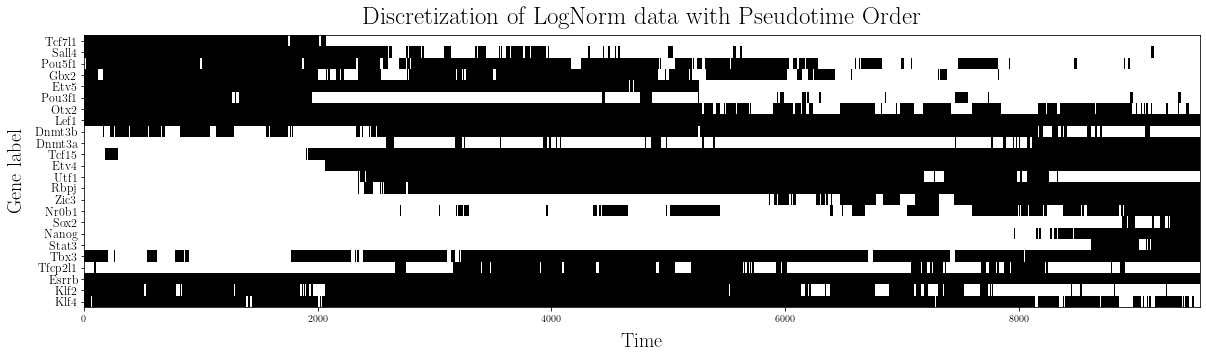

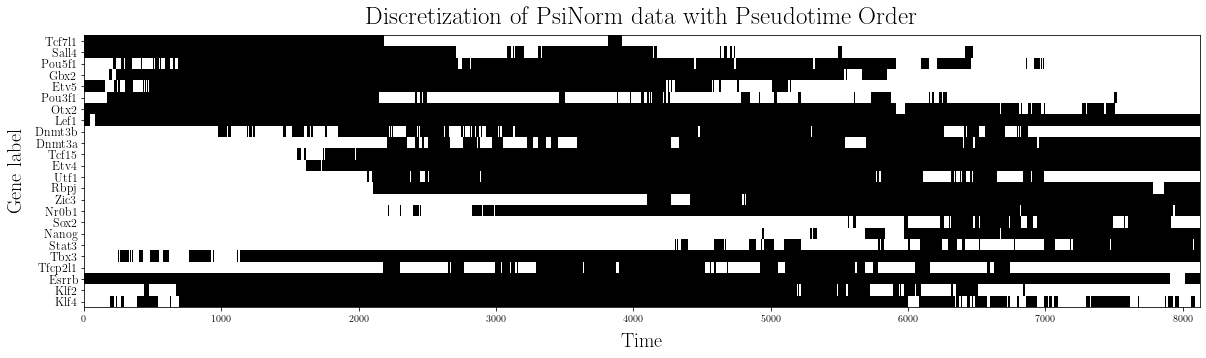

In [9]:
spins_df_lN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB_Spins.csv", header=0, index_col=0, sep=",")

fun_plotting.raster_plot(np.array(spins_df_lN_mb_pst), 'Discretization of LogNorm data with Pseudotime Order', 1, genes_order[::-1])
plt.show()


spins_df_pN_mb_pst = pd.read_csv(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB_Spins.csv", header=0, index_col=0, sep=",")

fun_plotting.raster_plot(np.array(spins_df_pN_mb_pst), 'Discretization of PsiNorm data with Pseudotime Order', 1, genes_order[::-1])
plt.show()



# Randomization

In [10]:
spins_df_lN_mb_pst_shuffle = np.load(path_data + "GE_data/processed/imp_genes_LogNorm_PST_MB_Spins_RND50Test.npy")
spins_df_pN_mb_pst_shuffle = np.load(path_data + "GE_data/processed/imp_genes_PsiNorm_PST_MB_Spins_RND50Test.npy")
 
Ntest = spins_df_lN_mb_pst_shuffle.shape[0] 




In [11]:
check=True
if check:
    # Check the reshuffle
    print(funcs_general.check_shuffle(spins_df_lN_mb_pst_shuffle, Ntest))
    print(funcs_general.check_shuffle(spins_df_pN_mb_pst_shuffle, Ntest))
    
    # zero expected if everithing is working fine

0.0
0.0


In [12]:
show = False
if show:
    for ii in range(0, Ntest, 60):
            fun_plotting.raster_plot(np.array(spins_df_lN_mb_pst_shuffle[ii,:,:]), 'Discretization of LogNorm data with PST - RND '+str(ii+1), 1, genes_order[::-1])
            plt.show()    
            fun_plotting.raster_plot(np.array(spins_df_pN_mb_pst_shuffle[ii,:,:]), 'Discretization of PsiNorm data with PST - RND '+str(ii+1), 1, genes_order[::-1])
            plt.show() 
            

# Known Experimentally

## Neighbours interactions

In [13]:
TPtrial_list = ["Stat3 Klf4 1", "Nanog Esrrb 1", "Stat3 Dnmt3b -1", 
                "Nanog Otx2 -1", "Nanog Pou3f1 -1",
                "Stat3 Gbx2 1", "Stat3 Tfcp2l1 1", 
                "Otx2 Pou3f1 1", "Otx2 Dnmt3a 1", 
                "Tcf7l1 Esrrb -1", "Tcf7l1 Klf2 -1", "Tcf7l1 Nanog -1", "Tcf7l1 Nr0b1 -1",  "Tcf7l1 Tfcp2l1 -1",  
                "Rbpj Nanog -1", "Rbpj Tbx3 -1", "Etv5 Lef1 1", "Etv5 Pou3f1 1"]


## Directed Correlations

In [14]:
df_KO_N24_Leeb_cl = pd.read_csv(path_data+'Leeb_Data_Orig/df_KO_N24_cleaned.csv', index_col=0, header=0)

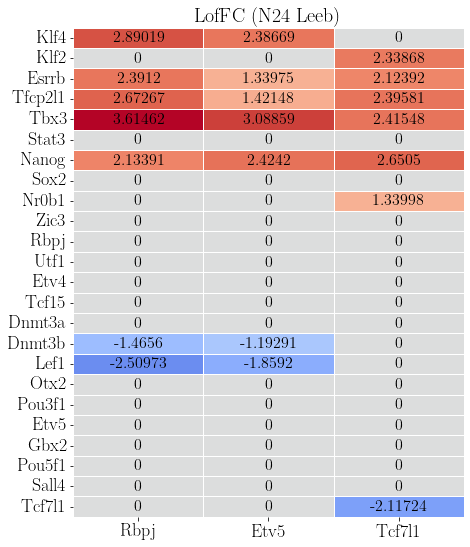

In [15]:
correlations_list = funcs_general.InteractionList(df_KO_N24_Leeb_cl, perc = 0.3)

fun_plotting.plot_log2FC(df_KO_N24_Leeb_cl, "LofFC (N24 Leeb)")

## Inferred Infos for LogNorm and PsiNorm

Threshold = 1% of the maximum

In [16]:
interaction_thr = 0.01
Ntrials = 150

today = "23_02_27" # or other data
data_type = "pst_MB"

# LOADING the data    
lN_arrays = np.load(path_data+'OUT_ISING/LogNORM/lN_arrays_'+data_type+'_'+str(today)+'.npz')#+'_thr'+str(interaction_thr*100)+'.npz')
lN_matx_sel_true = lN_arrays['array_1']
lN_prec_sel_true = lN_arrays['array_2']
lN_int_val_true = lN_arrays['array_3']

pN_arrays = np.load(path_data+'OUT_ISING/PsiNORM/pN_arrays_'+data_type+'_'+str(today)+'.npz')#+'_thr'+str(interaction_thr*100)+'.npz')
pN_matx_sel_true = pN_arrays['array_1']
pN_prec_sel_true = pN_arrays['array_2']
pN_int_val_true =  pN_arrays['array_3']


In [17]:
# load inferred data
lN_high_meanMatx = np.load(path_data + "OUT_ISING/LogNORM/LogNorm_InferredMatrix.npy")
lN_Mean_TP_frac  = np.load(path_data + "OUT_ISING/LogNORM/LogNorm_TPfrac.npy")
lN_Mean_info_int = np.load(path_data + "OUT_ISING/LogNORM/LogNorm_info_ints.npy")

pN_high_meanMatx = np.load(path_data + "OUT_ISING/PsiNORM/PsiNorm_InferredMatrix.npy")
pN_Mean_TP_frac  = np.load(path_data + "OUT_ISING/PsiNORM/PsiNorm_TPfrac.npy")
pN_Mean_info_int = np.load(path_data + "OUT_ISING/PsiNORM/PsiNorm_info_ints.npy")

## Interactions and Adjacency Matrix

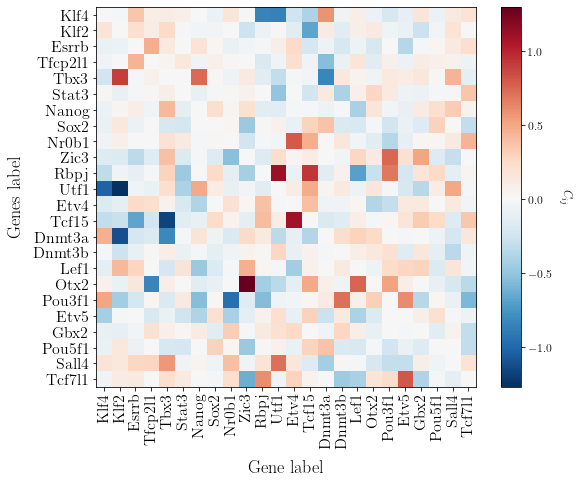

Min and Max values of J:  1.3011 -1.2723


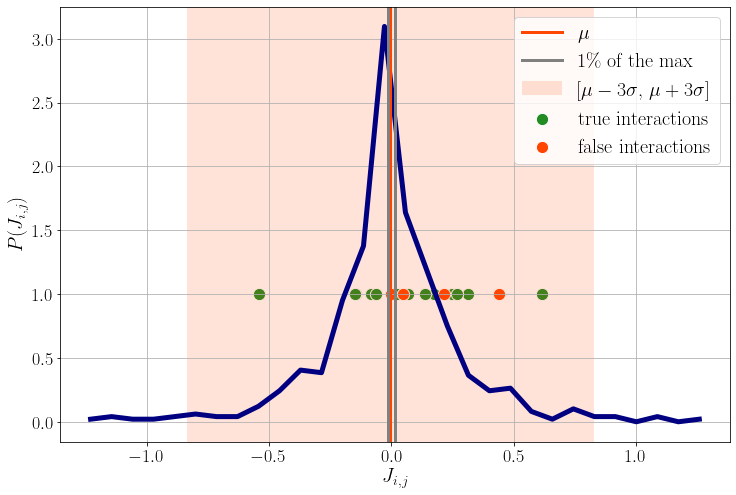

In [20]:
# Matrix of interactions and interactions distribution plots
# all interactions
na.intM_plot(lN_high_meanMatx)
print("Min and Max values of J: ", np.round(lN_high_meanMatx.max(),4), np.round(lN_high_meanMatx.min(),4))

# interactions above the threshold (decoment to see the plot)
# lN_high_meanMatx_thr = na.to_thr_matrix(lN_high_meanMatx, thr=interaction_thr)
# na.intM_plot(lN_high_meanMatx_thr)

na.interactions_plot(lN_high_meanMatx, lN_Mean_info_int, thr = interaction_thr)


Pearson correlation

In [53]:
# mini-bulk WITH PST on LogNorm
cm_lN_mb_pst = np.corrcoef(df_lN_mb_pst)
np.fill_diagonal(cm_lN_mb_pst, float("Nan")) 
na.intM_plot(cm_lN_mb_pst)

# mini-bulk WITH PST on PsiNorm
cm_pN_mb_pst = np.corrcoef(df_pN_mb_pst)
np.fill_diagonal(cm_pN_mb_pst, float("Nan"))

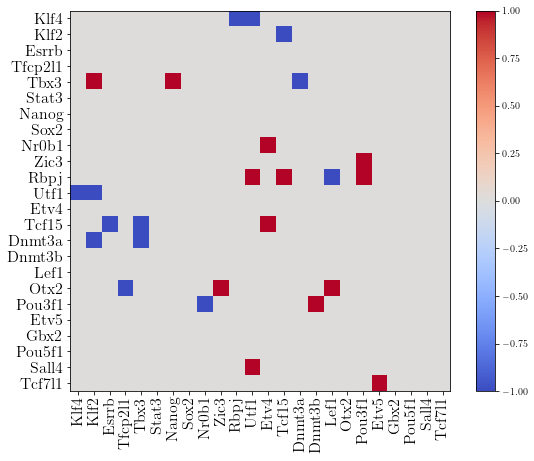

%1s : 0.02
%-1s : 0.02
%0s : 0.95


In [62]:
adj_matx = na.to_adj_matrix(lN_high_meanMatx, thr = 0.5)
na.adj_plot(adj_matx)

print("%1s :", f"{len(np.where(adj_matx==1)[0])/(adj_matx.shape[0]*adj_matx.shape[1]):.2f}")
print("%-1s :", f"{len(np.where(adj_matx==-1)[0])/(adj_matx.shape[0]*adj_matx.shape[1]):.2f}")

print("%0s :", f"{len(np.where(adj_matx==0)[0])/(adj_matx.shape[0]*adj_matx.shape[1]):.2f}")

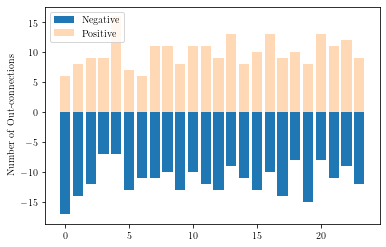

In [60]:
# calculate the number of positive connections for each edge
positive_connections = np.sum(np.clip(adj_matx, 0, 3), axis=0)

# calculate the number of negative connections for each edge
negative_connections = np.sum(np.clip(adj_matx, -3, 0), axis=0)

# sort the connections in descending order
positive_connections_sorted = np.sort(positive_connections)[::-1]
negative_connections_sorted = np.abs(np.sort(negative_connections))

# plot the positive connections
plt.bar(np.arange(len(negative_connections)), negative_connections, label="Negative")
plt.bar(np.arange(len(positive_connections)), positive_connections, label="Positive",alpha=0.3)


# plot the negative connections
# plt.xlabel("Edges Number")
plt.ylabel("Number of Out-connections")

plt.legend()
plt.show()


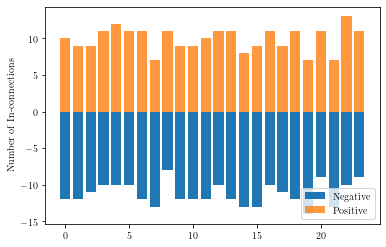

In [61]:
# calculate the number of positive connections for each edge
positive_connections = np.sum(np.clip(adj_matx, 0, 3), axis=1)

# calculate the number of negative connections for each edge
negative_connections = np.sum(np.clip(adj_matx, -3, 0), axis=1)

# sort the connections in descending order
positive_connections_sorted = np.sort(positive_connections)[::-1]
negative_connections_sorted = np.abs(np.sort(negative_connections))

# plot the positive connections
plt.bar(np.arange(len(negative_connections)), negative_connections, label="Negative")

plt.bar(np.arange(len(positive_connections)), positive_connections, label="Positive", alpha=0.8)
# plot the negative connections
# plt.xlabel("Edges Number")
plt.ylabel("Number of In-connections")
plt.legend()
plt.show()


In [62]:
np.sum(positive_connections_sorted[:5])/np.sum(positive_connections_sorted)

0.24369747899159663

In [63]:
np.sum(negative_connections_sorted[:5])/np.sum(negative_connections_sorted)

0.24444444444444444

## RECIPROCITY

In [64]:
reciprocity_value = na.reciprocity(adj_matx)
print(reciprocity_value)

0.87


/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/NetAnalysis.py:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(genes_list, rotation=45, fontsize=16)


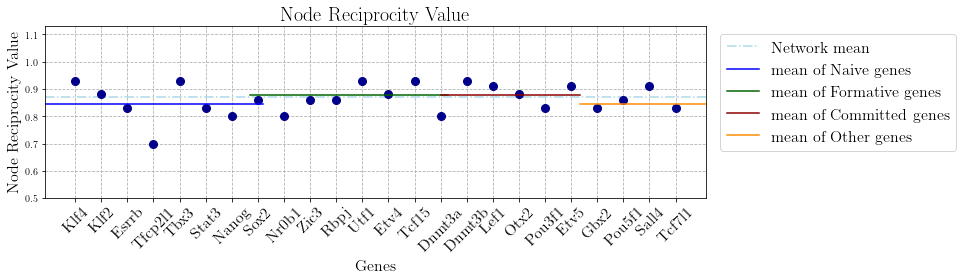

Naive 0.84 +\_ 0.07
Formative 0.88 +\_ 0.04
Committed 0.88 +\_ 0.05
Others 0.86 +\_ 0.03


In [65]:
nodes_rec, mean_TypeGenes, std_TypeGenes = na.nodes_reciprocity(adj_matx, net_reciprocity = reciprocity_value, genes_list=genes_order)

print("Naive", "{:.2f}".format(mean_TypeGenes[0]), "+\_", "{:.2f}".format(std_TypeGenes[0]))
print("Formative", "{:.2f}".format(mean_TypeGenes[1]), "+\_", "{:.2f}".format(std_TypeGenes[1]))
print("Committed", "{:.2f}".format(mean_TypeGenes[2]), "+\_", "{:.2f}".format(std_TypeGenes[2]))
print("Others", "{:.2f}".format(mean_TypeGenes[3]), "+\_", "{:.2f}".format( std_TypeGenes[3]))





## DEGREE

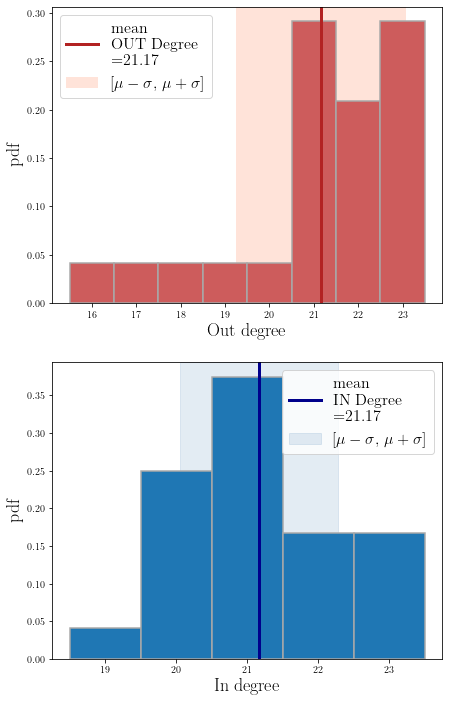

In [66]:
na.plot_degree_distribution(adj_matx)


23.0 23.0


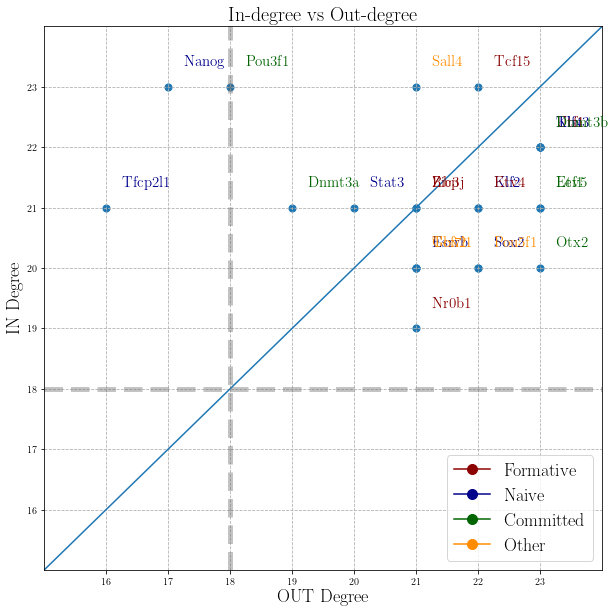

0.02


In [67]:
outdegree, indegree, Sp_corr = na.plot_indegree_outdegree(adj_matx)
print(f"{Sp_corr:.2f}")

## INTERACTION DISTRIBUTION

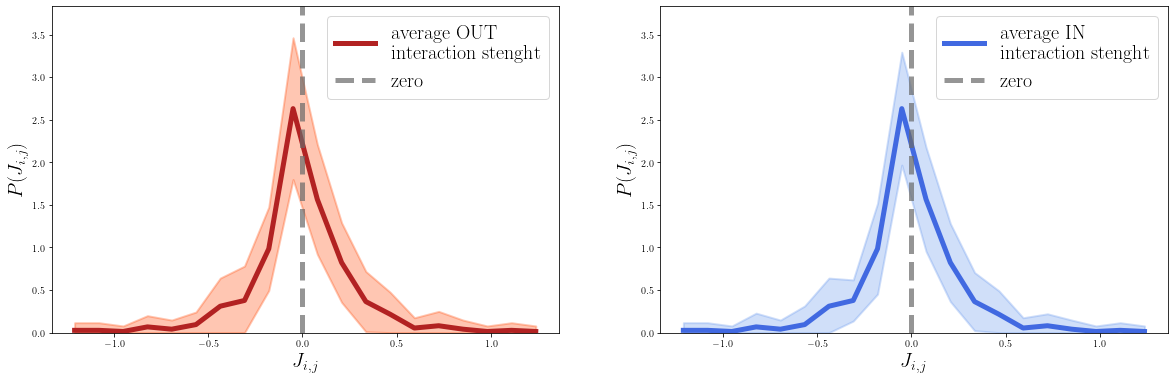

In [68]:
na.plot_histograms(lN_high_meanMatx)


### Hubs

OUT hubs:
 ['Klf4' 'Tbx3' 'Utf1' 'Dnmt3b' 'Lef1']
IN hubs:
 ['Nanog' 'Tcf15' 'Pou3f1' 'Sall4' 'Klf4']
OUT hubs


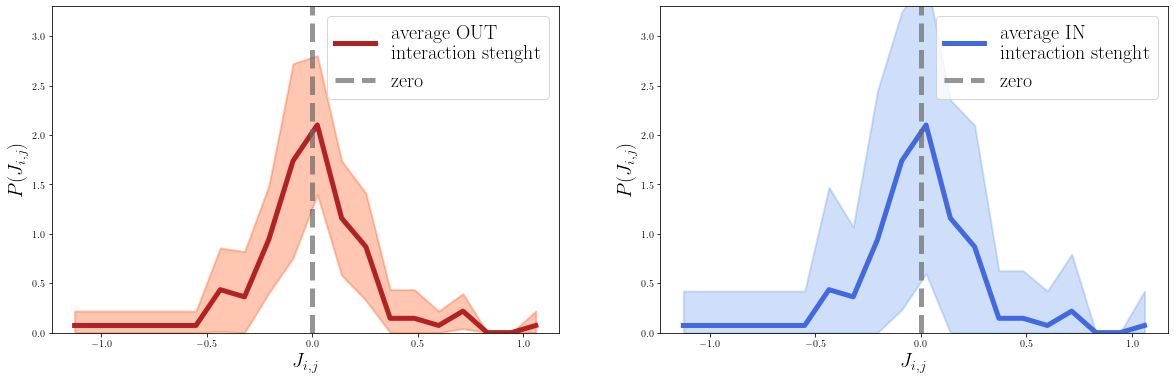

IN hubs


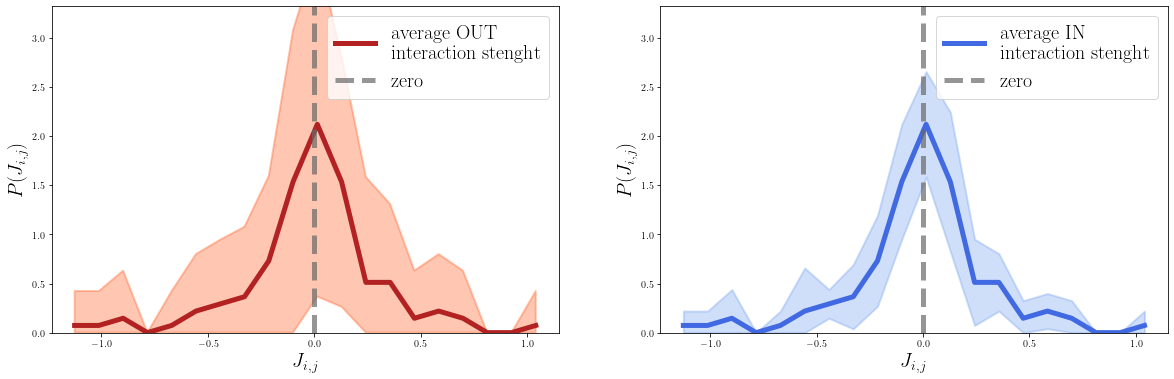

In [69]:
n_hubs = 5
print("OUT hubs:\n", na.highest_OUTdegree_nodes(adj_matx, n_hubs, genes_order)[:,0])
print("IN hubs:\n", na.highest_INdegree_nodes(adj_matx, n_hubs, genes_order)[:,0])

print("OUT hubs")
out_hubs_idxs = na.highest_OUTdegree_nodes(adj_matx, n_hubs, genes_order)[:,2]
na.plot_histograms(lN_high_meanMatx[:,out_hubs_idxs.astype("int")])

print("IN hubs")
in_hubs_idxs = na.highest_INdegree_nodes(adj_matx, n_hubs, genes_order)[:,2]
na.plot_histograms(lN_high_meanMatx[in_hubs_idxs.astype("int"), :])


## NETWORK

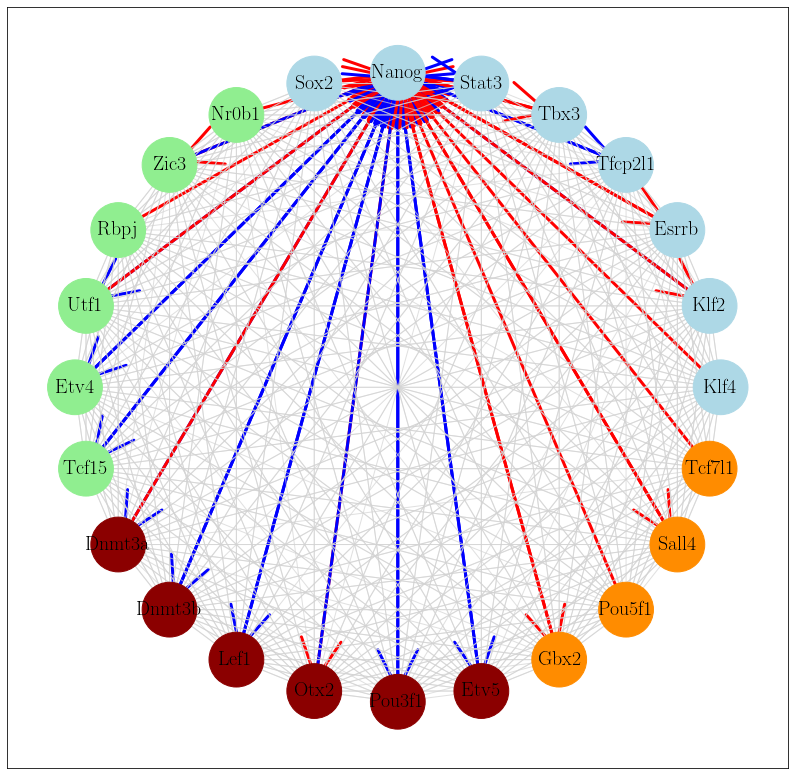

In [70]:
na.visualize_graph_selNode(adj_matx, genes_order, naive, formative, committed, "Nanog")



In [71]:
interactions = na.string_list_to_tuple(TPtrial_list)
correlations_known = na.string_list_to_tuple(Interactions_list)

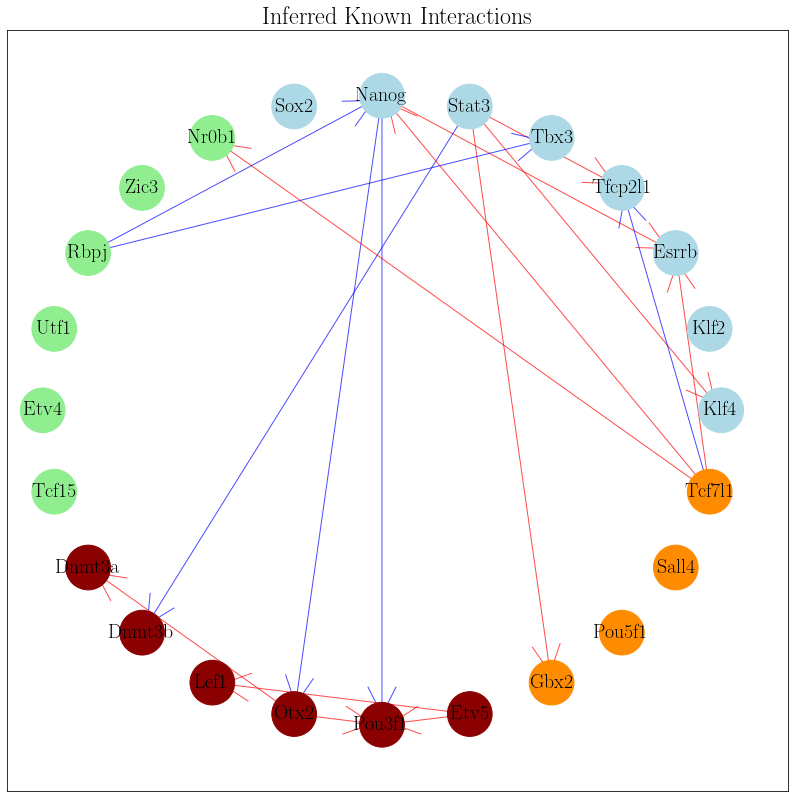

In [72]:
na.visualize_graph_KnownInferred(adj_matx, genes_order, naive, formative, committed,  interactions, "Inferred Known Interactions")
# 

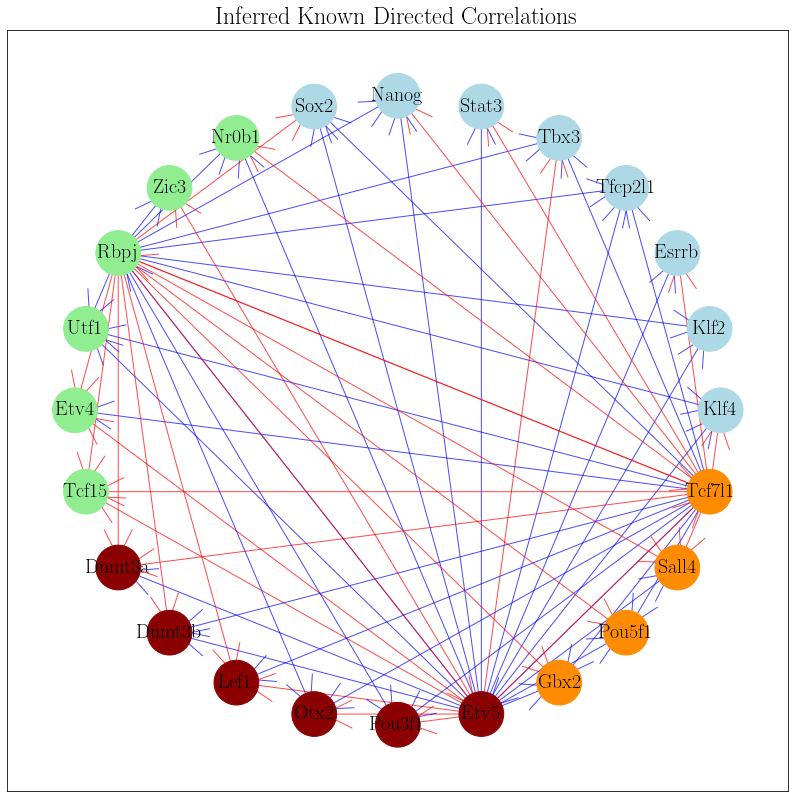

In [73]:
na.visualize_graph_KnownInferred(adj_matx, genes_order, naive, formative, committed,  correlations_known, "Inferred Known Directed Correlations")


# Nentwork Analysis: PsiNorm PST MB

## Interactions and Adjacency Matrix

In [74]:
thr = 0.01

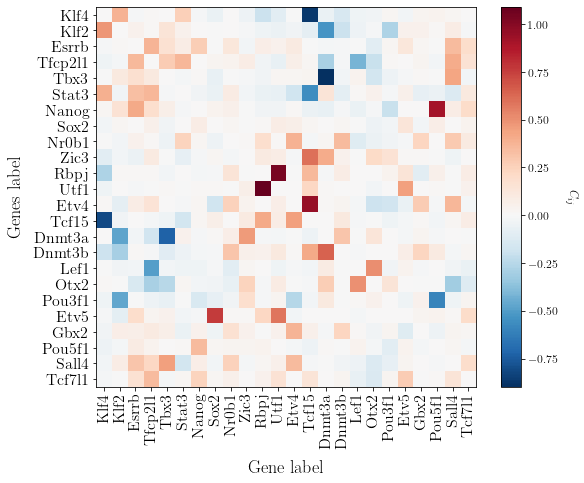

In [75]:
na.intM_plot(pN_high_meanMatx)

Min and Max values of J:  1.0913 -0.8997
0.054565184362132015


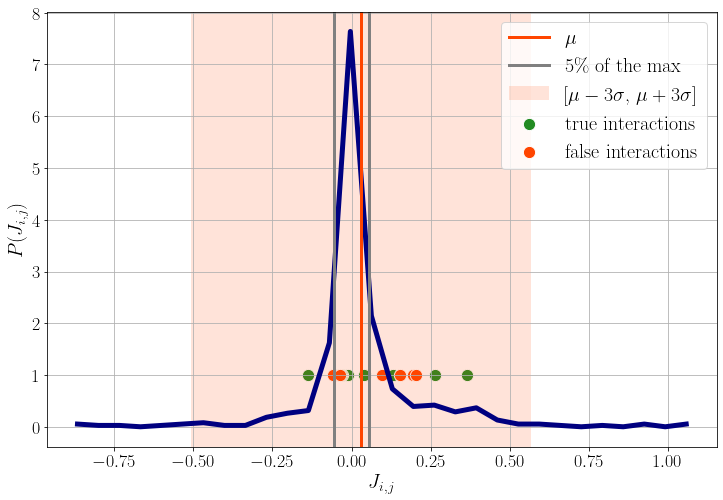

In [76]:
print("Min and Max values of J: ", np.round(pN_high_meanMatx.max(),4), np.round(pN_high_meanMatx.min(),4))

na.interactions_plot(pN_high_meanMatx, pN_high_info_int)

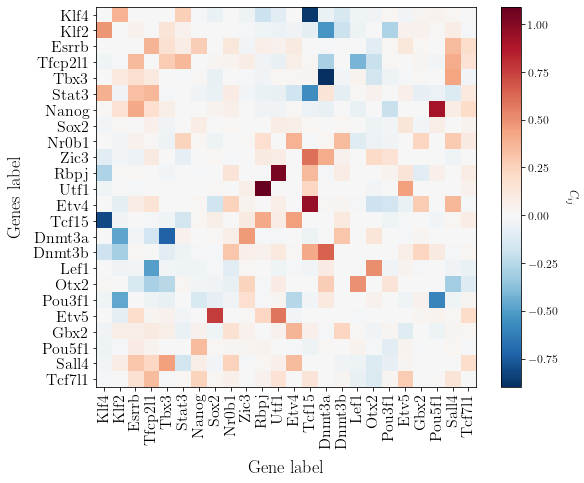

In [77]:
pN_high_meanMatx_thr = na.to_thr_matrix(pN_high_meanMatx, thr=thr)
na.intM_plot(pN_high_meanMatx_thr)

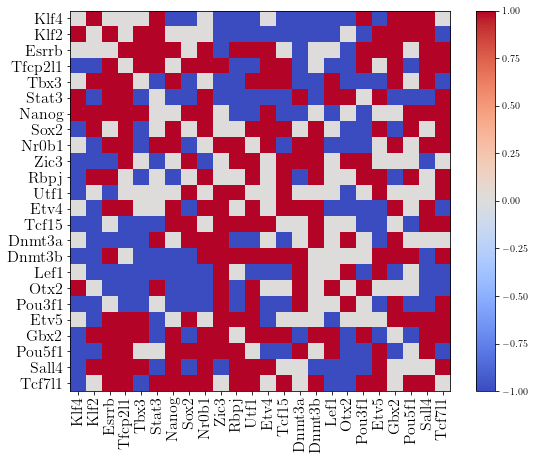

%1s : 0.41
%-1s : 0.32
%0s : 0.27


In [78]:
adj_matx = na.to_adj_matrix(pN_high_meanMatx, thr = thr)
na.adj_plot(adj_matx)

print("%1s :", f"{len(np.where(adj_matx==1)[0])/(adj_matx.shape[0]*adj_matx.shape[1]):.2f}")
print("%-1s :", f"{len(np.where(adj_matx==-1)[0])/(adj_matx.shape[0]*adj_matx.shape[1]):.2f}")

print("%0s :", f"{len(np.where(adj_matx==0)[0])/(adj_matx.shape[0]*adj_matx.shape[1]):.2f}")

## RECIPROCITY

In [79]:
reciprocity_value = na.reciprocity(adj_matx)
print(reciprocity_value)

0.75


/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/NetAnalysis.py:172: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(genes_list, rotation=45, fontsize=16)


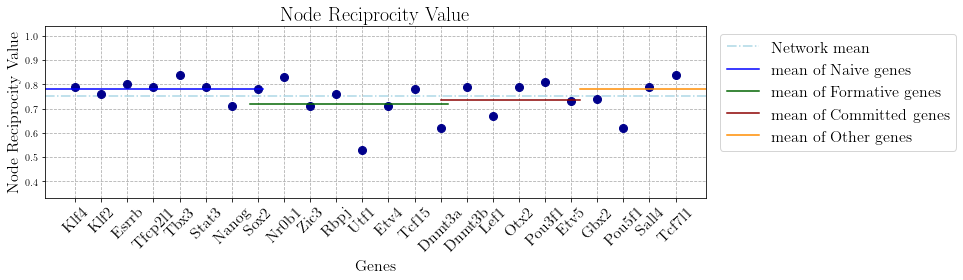

Naive 0.78 +\_ 0.03
Formative 0.72 +\_ 0.09
Committed 0.73 +\_ 0.07
Others 0.75 +\_ 0.08


In [80]:
nodes_rec, mean_TypeGenes, std_TypeGenes = na.nodes_reciprocity(adj_matx, net_reciprocity = reciprocity_value, genes_list=genes_order)

print("Naive", "{:.2f}".format(mean_TypeGenes[0]), "+\_", "{:.2f}".format(std_TypeGenes[0]))
print("Formative", "{:.2f}".format(mean_TypeGenes[1]), "+\_", "{:.2f}".format(std_TypeGenes[1]))
print("Committed", "{:.2f}".format(mean_TypeGenes[2]), "+\_", "{:.2f}".format(std_TypeGenes[2]))
print("Others", "{:.2f}".format(mean_TypeGenes[3]), "+\_", "{:.2f}".format( std_TypeGenes[3]))





## DEGREE

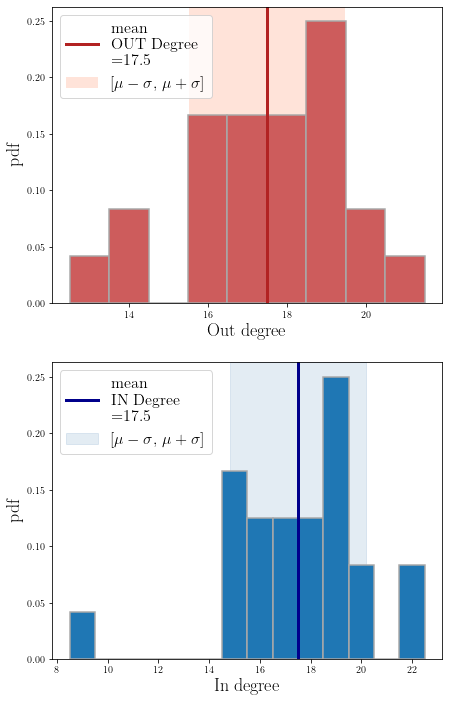

In [81]:
na.plot_degree_distribution(adj_matx)


22.0 21.0


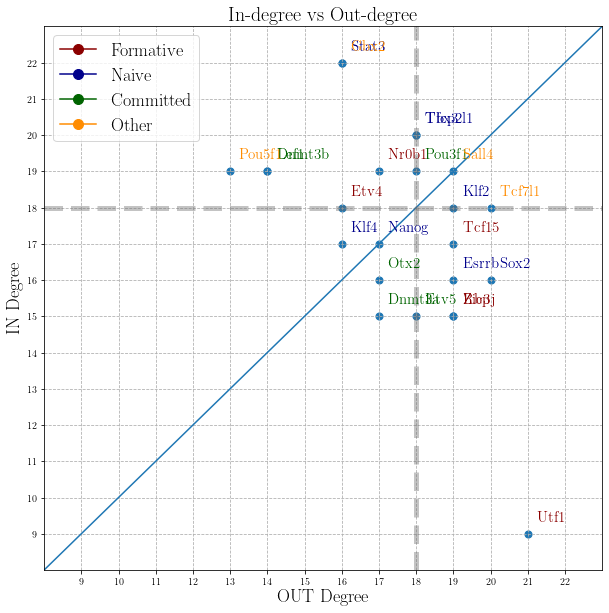

-0.49


In [82]:
outdegree, indegree, Sp_corr = na.plot_indegree_outdegree(adj_matx)
print(f"{Sp_corr:.2f}")

In [83]:
print(np.mean(outdegree), np.mean(indegree))

17.5 17.5


## INTERACTION DISTRIBUTION

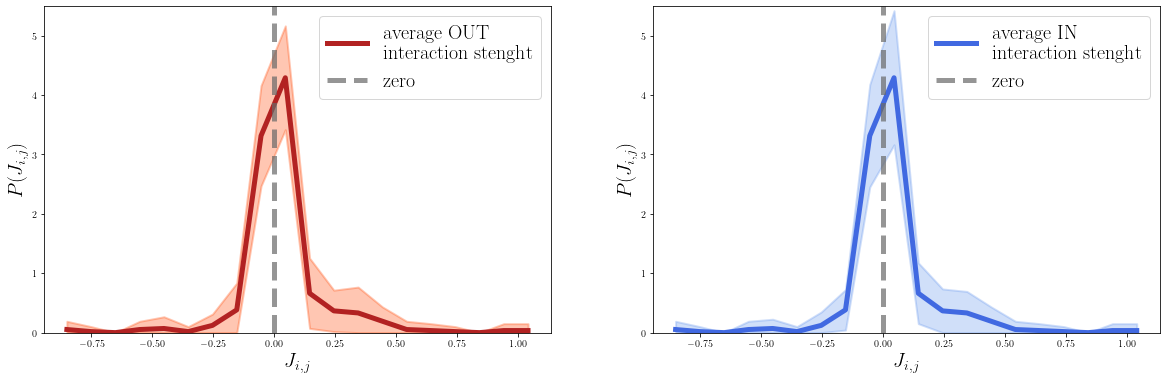

In [84]:
na.plot_histograms(pN_high_meanMatx)


### Hubs

OUT hubs:
 ['Utf1' 'Sox2' 'Tcf7l1' 'Klf2' 'Esrrb']
IN hubs:
 ['Stat3' 'Gbx2' 'Tfcp2l1' 'Tbx3' 'Nr0b1']
OUT hubs


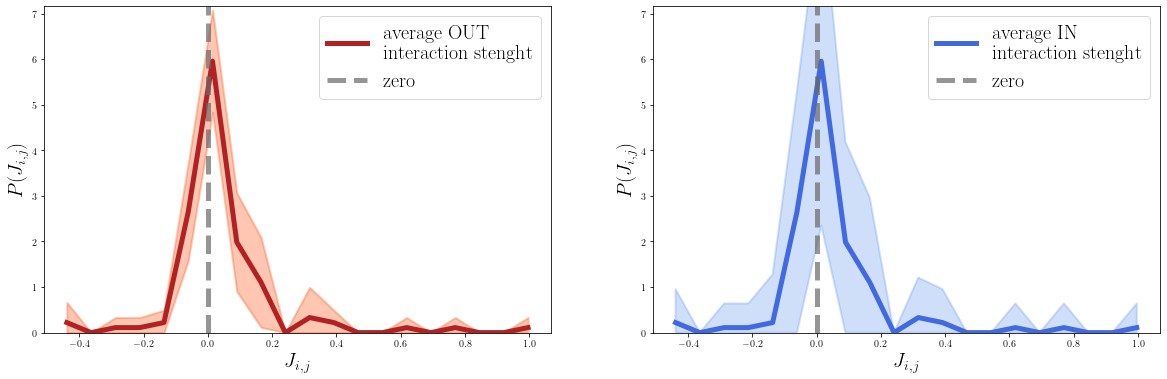

IN hubs


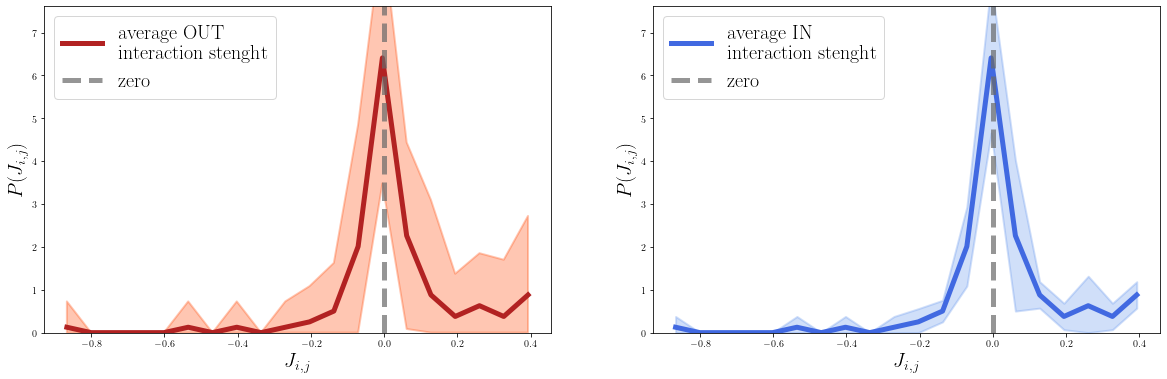

In [85]:
n_hubs=5

print("OUT hubs:\n", na.highest_OUTdegree_nodes(adj_matx, n_hubs, genes_order)[:,0])
print("IN hubs:\n", na.highest_INdegree_nodes(adj_matx, n_hubs, genes_order)[:,0])

print("OUT hubs")
out_hubs_idxs = na.highest_OUTdegree_nodes(adj_matx, n_hubs, genes_order)[:,2]
na.plot_histograms(pN_high_meanMatx[:,out_hubs_idxs.astype("int")])

print("IN hubs")
in_hubs_idxs = na.highest_INdegree_nodes(adj_matx, n_hubs, genes_order)[:,2]
na.plot_histograms(pN_high_meanMatx[in_hubs_idxs.astype("int"), :])


## NETWORK

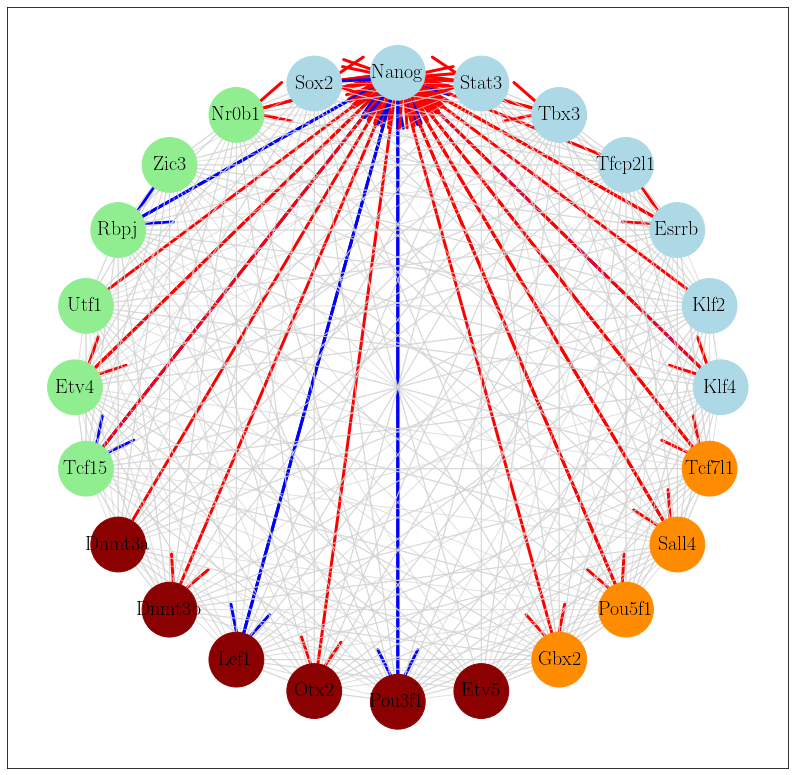

In [86]:
na.visualize_graph_selNode(adj_matx, genes_order, naive, formative, committed, "Nanog")



In [87]:
interactions = na.string_list_to_tuple(TPtrial_list)
correlations_known = na.string_list_to_tuple(Interactions_list)

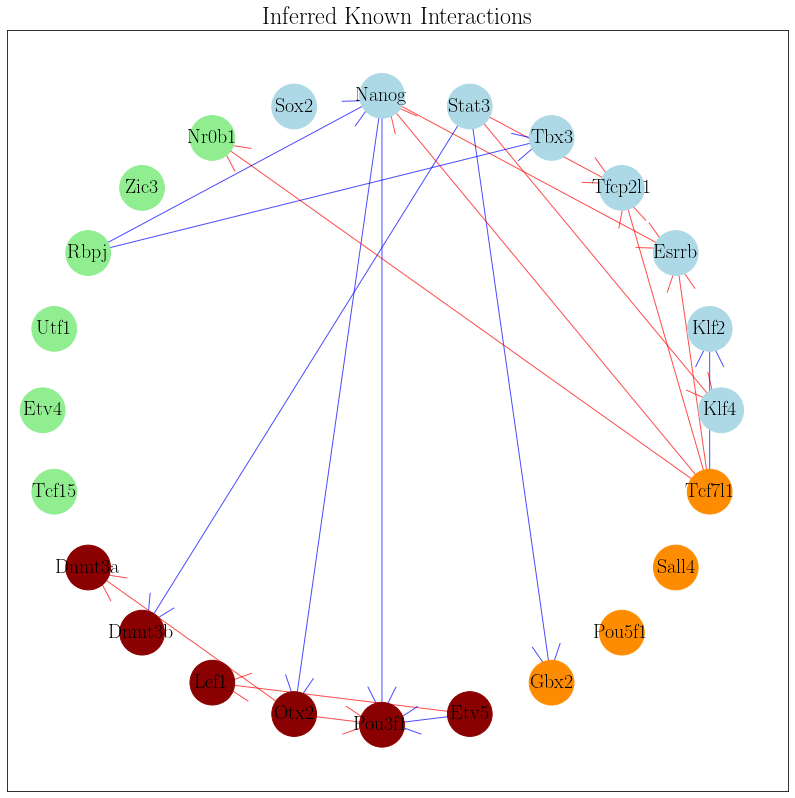

In [88]:
na.visualize_graph_KnownInferred(adj_matx, genes_order, naive, formative, committed,  interactions, "Inferred Known Interactions")


In [89]:
# na.visualize_graph_KnownInferred(bin_matx, genes_order, naive, formative, committed,  correlations_known, "Inferred Known Directed Correlations")


# Data generation

In [90]:
np.random.seed(20961)    #(10101959)#(20091961)
Ntrials = 150

for ii in range(Ntrials):
    par_sel = {}
    for jj in params.keys():
        par_sel[jj] = np.random.choice(params[jj])
    if ii==31: #31 for PST MB lognorm
        print("\nParams for LogNorm\n", par_sel)
    if ii==147: #31 for PST MB lognorm
        print("\nParams for  PsiNorm\n", par_sel)
#     if ii==96:
#         print("\nParams for PsiNorm\n", par_sel) 


Params for LogNorm
 {'LAMBDA': 0.04, 'lr': 0.4, 'drop': 0.85, 'edrop': 15, 'opt': 'MOMENTUM', 'MOM': 0.99, 'reg': 'L1', 'Nepochs': 500}

Params for  PsiNorm
 {'LAMBDA': 0.03, 'lr': 0.6, 'drop': 0.99, 'edrop': 15, 'opt': 'MOMENTUM', 'MOM': 0.95, 'reg': 'L1', 'Nepochs': 900}


## LogNorm

/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/ml_wrapper.py:34: RuntimeWarning: divide by zero encountered in arctanh
  self.h = np.arctanh(np.mean(x, axis = 1))
/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/fun_asynch.py:171: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  return 1/delta_t*(np.dot(spins[:,1:], spins[:,:-1].T)/Nsteps - cov)
OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Epoch 	 Max J gradient 	 Max h gradient 	 Max change in J 	 Max change in h 	 Likelihood


/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/fun_asynch.py:269: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 2d, A))
  gJ = nb_dJ(cov, dot_cov, spins, new_h, new_J, theta)


0 	 0.999895 	 1.0 	 0.4126 	 0.384 	 -0.5504479786551469
100 	 0.339555 	 0.233825 	 0.2829 	 0.0621 	 -4.153041676518795
200 	 0.331083 	 0.301216 	 0.1062 	 0.0478 	 -3.1320863957484186
300 	 0.241861 	 0.190668 	 0.051 	 0.0332 	 -2.6184842870878797
400 	 0.21405 	 0.214354 	 0.0235 	 0.0127 	 -2.351544290862687


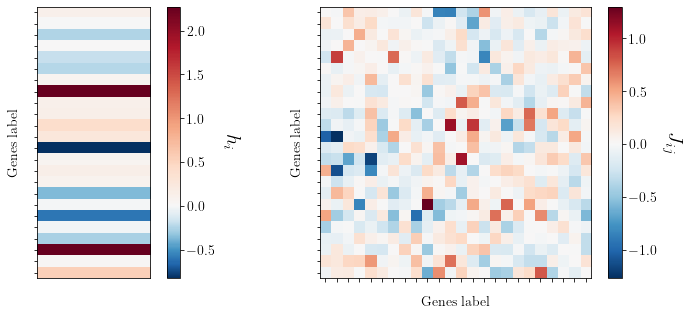


RESULTS for scRNA-seq PST MB with ISING

TP fraction: 0.67

Interaction values:
 [ 0.069  0.175 -0.085 -0.146 -0.542  0.023  0.137  0.312  0.247  0.214
 -0.001  0.048  0.438 -0.063 -0.147 -0.148  0.269  0.614]

TP ints values:
 [ 0.069  0.175 -0.085 -0.146 -0.542  0.     0.137  0.312  0.247  0.
 -0.     0.     0.    -0.    -0.147 -0.148  0.269  0.614]


In [91]:
# initialize the reconstruction
Nepochs = 500
LAMBDA = 0.04
lr = 0.4
drop = 0.85
edrop = 15

np.random.seed(1234)
model_lN_best = asynch_reconstruction(np.array(spins_df_lN_mb_pst), delta_t = 1, LAMBDA = LAMBDA, opt = 'MOMENTUM', MOM=0.99, reg = 'L1')

# reconstruct the model 
np.random.seed(1234)
model_lN_best.reconstruct(np.array(spins_df_lN_mb_pst), Nepochs = Nepochs, start_lr = lr, drop = drop, edrop = edrop)

lN_rec_tp_val, lN_rec_info_int, lN_rec_matx = TP_plot(TPtrial_list, model_lN_best.J, genes_order, 
                                                   inferred_int_thr=0.05, Norm_Matx = False,
                                                   data_type="scRNA-seq PST MB with ISING",
                                                   figplot=False, verbose=True, nbin=30, Norm=True)



### Analysis of simulated Data

/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/GRN_Inference_CODE/lib/fun_asynch.py:135: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, C), array(float64, 1d, A))
  slist[:,idx+1] = asynch_glauber_dynamics(h, J, slist[:,idx], delta_t, gamma)


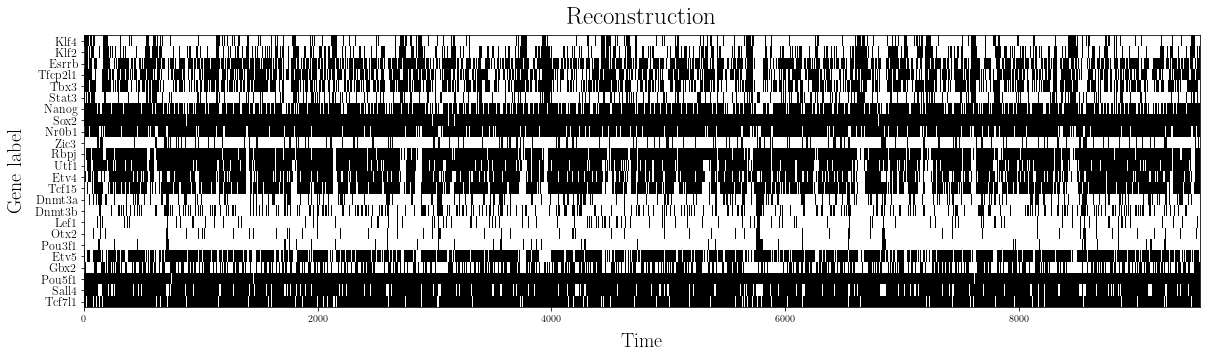

In [92]:
#generate new data
np.random.seed(1234)
spins_new_lN = model_lN_best.generate_samples()
fun_plotting.raster_plot(spins_new_lN, 'Reconstruction', 1,genes_order)
plt.show()

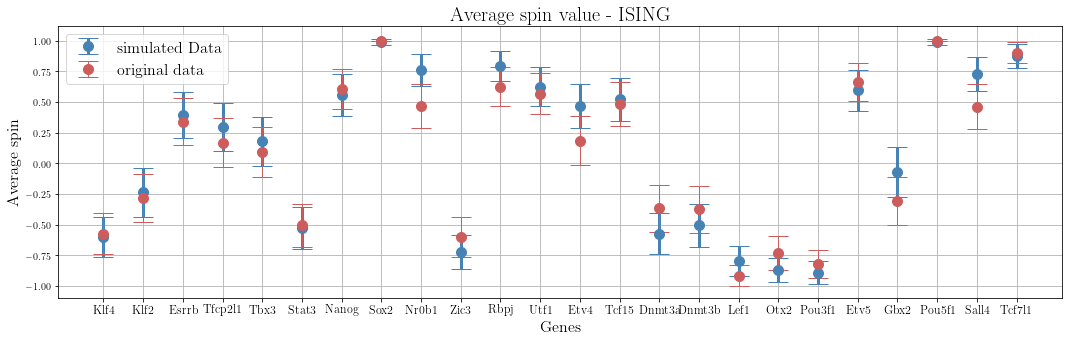

In [93]:
plt.figure(figsize=(18,5))
plt.errorbar(genes_order, spins_new_lN.mean(axis=1), yerr=spins_new_lN.std(axis=1)/np.sqrt(24),  
             alpha=1, 
             fmt="o", ms = 10,
             elinewidth=3,
             color="steelblue",
             capsize=10,
             label= "simulated Data")

plt.errorbar(genes_order, spins_df_lN_mb_pst.mean(axis=1), yerr=spins_df_lN_mb_pst.std(axis=1)/np.sqrt(24), 
             alpha=1, 
             fmt="o", ms = 10,
             elinewidth=1,
             color="indianred",
             capsize=10,
             label = "original data")
plt.legend(loc="upper left", fontsize=16)
plt.xticks(fontsize=12)
plt.ylabel("Average spin", fontsize=16)
plt.xlabel("Genes", fontsize=16)
plt.title("Average spin value - ISING", fontsize=20)
plt.grid(True)

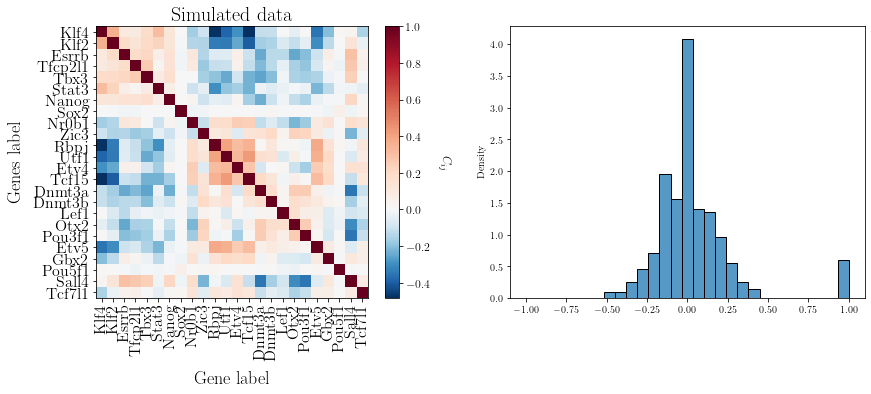

(array([], dtype=int64), array([], dtype=int64))


/var/folders/2z/hsgwjl3d49109llzgvkyf6jw0000gn/T/ipykernel_59632/1346890008.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(np.where(spins_new_lN==np.float("nan")))


In [94]:
cm_sim = np.corrcoef(spins_new_lN)

bins = np.linspace(-1, 1, 30)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
figfunc.plotmat(cm_sim, fig, ax[0], genes_order, "Simulated data")
sns.histplot(np.ndarray.flatten(cm_sim), bins=bins,  ax=ax[1], stat="density")
plt.show()

# plt.imshow(np.corrcoef(spins_new_lN))
print(np.where(spins_new_lN==np.float("nan")))

/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2642: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2643: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


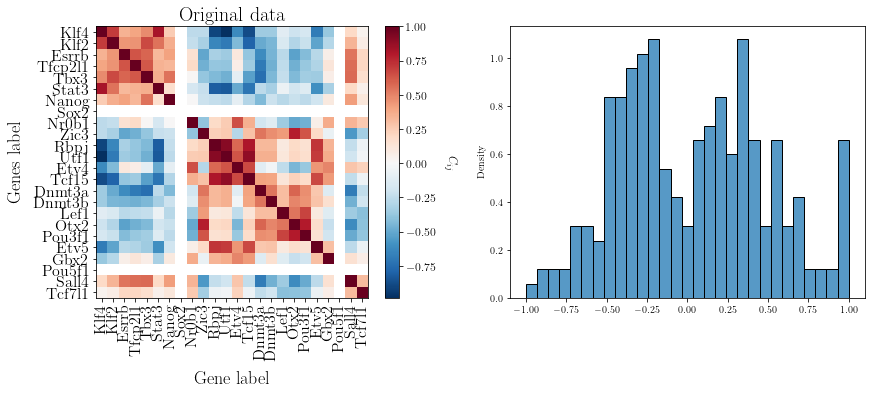

In [95]:
cm_original = np.corrcoef(spins_df_lN_mb_pst)

bins = np.linspace(-1, 1, 30)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
figfunc.plotmat(cm_original, fig, ax[0], genes_order, "Original data")
sns.histplot(np.ndarray.flatten(cm_original), bins=bins,  ax=ax[1], stat="density")
plt.show()



In [96]:
corr_matxs_rnd_lN = np.array([np.corrcoef(spins_df_lN_mb_pst_shuffle[i,:,:]) for i in range(50)])


In [97]:
cm_orig_red = cm_original.copy()
cm_orig_red = np.delete(cm_orig_red, 7, axis=0)
cm_orig_red = np.delete(cm_orig_red, 7, axis=1)
cm_orig_red = np.delete(cm_orig_red, 20, axis=0)
cm_orig_red = np.delete(cm_orig_red, 20, axis=1)


corr_matx_rnd_lN_red = np.delete(corr_matxs_rnd_lN, 7, axis=1)
corr_matx_rnd_lN_red = np.delete(corr_matx_rnd_lN_red, 7, axis=2)
corr_matx_rnd_lN_red = np.delete(corr_matx_rnd_lN_red, 20, axis=1)
corr_matx_rnd_lN_red = np.delete(corr_matx_rnd_lN_red, 20, axis=2)
print(corr_matx_rnd_lN_red.shape)

cm_sim_red = cm_sim.copy()
cm_sim_red = np.delete(cm_sim_red, 7, axis=0)
cm_sim_red = np.delete(cm_sim_red, 7, axis=1)
cm_sim_red = np.delete(cm_sim_red, 20, axis=0)
cm_sim_red = np.delete(cm_sim_red, 20, axis=1)

# cm_sim_SCODE_PST_MB_LogNorm = np.loadtxt('cm_sim_SCODE_MB_LogNorm.txt')
# cm_sim_SCODE_red = cm_sim_SCODE_PST_MB_LogNorm.copy()
# cm_sim_SCODE_red = np.delete(cm_sim_SCODE_red, 7, axis=0)
# cm_sim_SCODE_red = np.delete(cm_sim_SCODE_red, 7, axis=1)
# cm_sim_SCODE_red = np.delete(cm_sim_SCODE_red, 20, axis=0)
# cm_sim_SCODE_red = np.delete(cm_sim_SCODE_red, 20, axis=1)





(50, 22, 22)


In [98]:
# # Find all positions with NaN values
# nan_rows = np.where(np.all(np.isnan(cm_sim_SCODE_red), axis=1))[0]
# nan_cols = np.where(np.all(np.isnan(cm_sim_SCODE_red), axis=0))[0]
# print(nan_cols, nan_rows)


# cm_sim_SCODE_red = np.delete(cm_sim_SCODE_red, nan_rows, axis=0)
# cm_sim_SCODE_red = np.delete(cm_sim_SCODE_red, nan_cols, axis=1)

# cm_sim_red = np.delete(cm_sim_red, nan_rows, axis=0)
# cm_sim_red = np.delete(cm_sim_red, nan_cols, axis=1)

# cm_orig_red = np.delete(cm_orig_red, nan_rows, axis=0)
# cm_orig_red = np.delete(cm_orig_red, nan_cols, axis=1)

# print(corr_matx_rnd_red.shape)
# corr_matx_rnd_red = np.delete(corr_matx_rnd_red, nan_rows, axis=0)
# corr_matx_rnd_red = np.delete(corr_matx_rnd_red, nan_rows, axis=1)


In [99]:
genes_selected = np.delete(genes_order, [7,20])
# genes_selected = np.delete(genes_selected, nan_rows)
len(genes_selected)


22

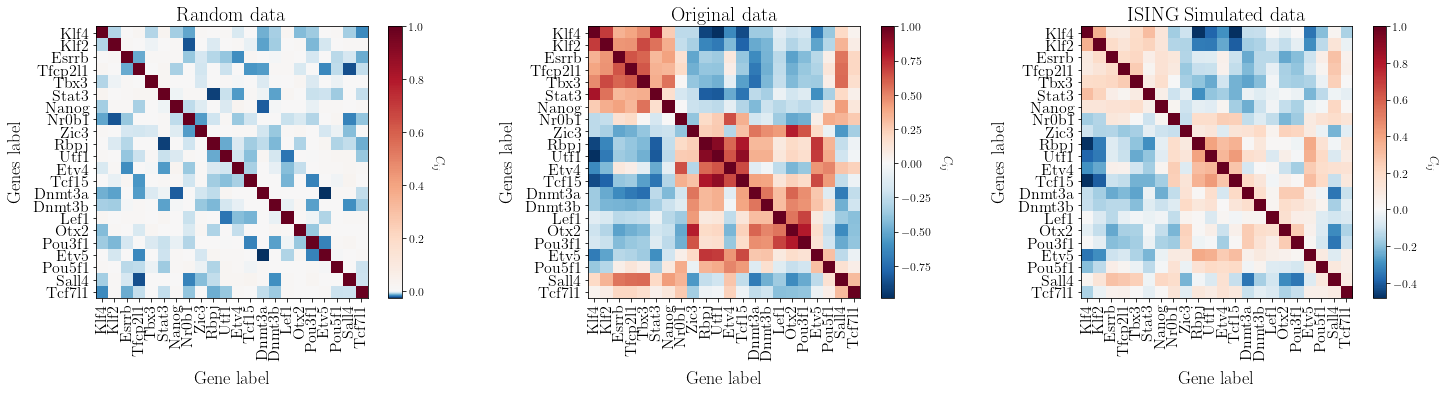

In [100]:
# cm_rnd = np.random.permutation(cm_orig_red.flatten()).reshape((cm_orig_red.shape[0], cm_orig_red.shape[1]))
cm_rnd = corr_matx_rnd_lN_red.copy()
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
figfunc.plotmat(corr_matx_rnd_lN_red[0,:,:], fig, ax[0], genes_selected, "Random data", )
figfunc.plotmat(cm_orig_red, fig, ax[1], genes_selected, "Original data")
figfunc.plotmat(cm_sim_red, fig, ax[2], genes_selected, "ISING Simulated data")
# figfunc.plotmat(cm_sim_SCODE_red, fig, ax[3], genes_selected, "SCODE Simulated data")
plt.show()



In [101]:
def sum_squared_abs_diff(array1, array2):
    diff = (array1.flatten()-array2.flatten())**2
    return np.sqrt(np.sum(diff))

In [102]:
noise_dist = [sum_squared_abs_diff(cm_orig_red, corr_matx_rnd_lN_red[i,:,:]) for i in range(50)]
noise_dist = np.mean(noise_dist)

result_IO = sum_squared_abs_diff(cm_orig_red, cm_sim_red) / noise_dist
print(f"Ising - Orig {result_IO:.2f}")

# result_SO = sum_squared_abs_diff(cm_orig_red, cm_sim_SCODE_red)/noise_dist
# print(f"Scode - Orig {result_SO:.2f}")

# restult_IS = sum_squared_abs_diff(cm_sim_red, cm_sim_SCODE_red)/noise_dist
# print(f"Scode - Ising {restult_IS:.2f}")

Ising - Orig 0.62


### Clustering on Simulated Data

In [103]:
# Perform linkage on your numpy array
Z = linkage(spins_new_lN.T, method='ward')


NameError: name 'linkage' is not defined

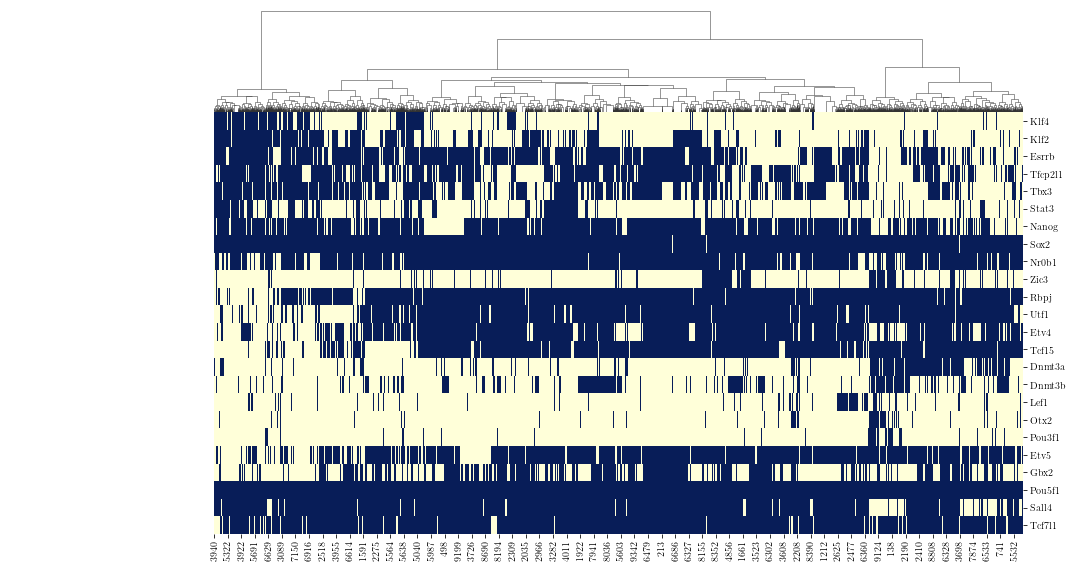

In [ ]:
# Plot the dendrogram and heatmap
sns.clustermap(spins_new_lN, col_linkage=Z, cmap='YlGnBu',yticklabels=genes_order,cbar=False, figsize=(15,8), row_cluster=False )
plt.xticks([])
plt.yticks([])
plt.show()


### Clustering on Original Data

In [ ]:
# Perform linkage on your numpy array
Z = linkage(spins_df_lN_mb_pst.T, method='ward')


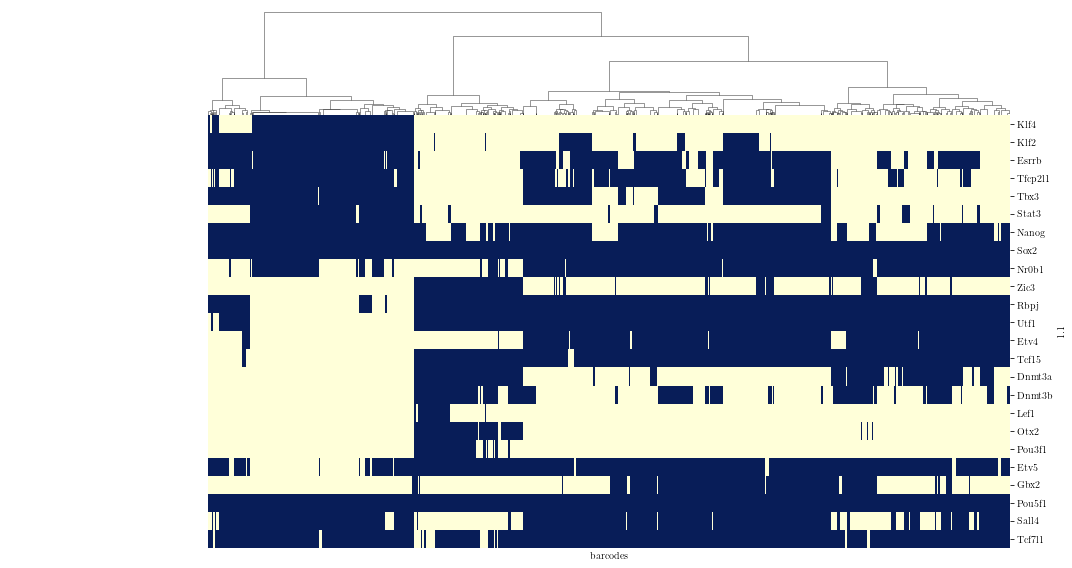

In [ ]:
# Plot the dendrogram and heatmap
sns.clustermap(spins_df_lN_mb_pst, col_linkage=Z, cmap='YlGnBu',
               yticklabels=genes_order, xticklabels=[],
               cbar=False, figsize=(15,8), row_cluster=False )

plt.xticks([])
plt.yticks([])

plt.show()


## PsiNorm

Epoch 	 Max J gradient 	 Max h gradient 	 Max change in J 	 Max change in h 	 Likelihood
0 	 0.964919 	 0.991136 	 0.5811 	 0.5767 	 -0.5353190542391589
100 	 0.162011 	 0.135921 	 0.3117 	 0.0892 	 -1.5777041946090808
200 	 0.323287 	 0.323356 	 0.204 	 0.1114 	 -1.4776633711445302
300 	 0.234006 	 0.185782 	 0.0708 	 0.027 	 -1.4487074707621825
400 	 0.163408 	 0.164035 	 0.079 	 0.0235 	 -1.4456851955098475
500 	 0.121376 	 0.122625 	 0.0516 	 0.0236 	 -1.423953858376333
600 	 0.074191 	 0.044772 	 0.045 	 0.0298 	 -1.4463964740987436
700 	 0.106101 	 0.106756 	 0.0471 	 0.0353 	 -1.4512194396870746
800 	 0.067431 	 0.044323 	 0.0398 	 0.0199 	 -1.4363900187622274


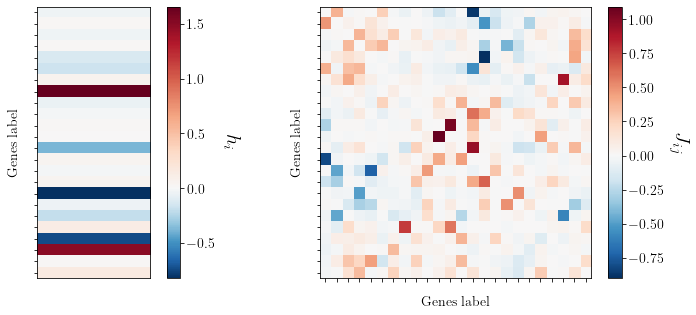


RESULTS for scRNA-seq PST MB with ISING

TP fraction: 0.28

Interaction values:
 [ 0.263  0.265 -0.049 -0.023 -0.137 -0.059  0.365  0.043  0.131  0.194
 -0.012  0.203  0.097  0.154 -0.03  -0.034  0.039 -0.037]

TP ints values:
 [ 0.263  0.265 -0.    -0.    -0.137 -0.     0.365  0.     0.131  0.
 -0.     0.     0.     0.    -0.    -0.     0.    -0.   ]


In [ ]:
# initialize the reconstruction
Nepochs = 900
LAMBDA = 0.03
lr = 0.6
drop = 0.99
edrop = 15

np.random.seed(1234)
model_pN_best = asynch_reconstruction(np.array(spins_df_pN_mb_pst), delta_t = 1, LAMBDA = LAMBDA, opt = 'MOMENTUM', MOM=0.95, reg = 'L1')

# reconstruct the model 
np.random.seed(1234)
model_pN_best.reconstruct(np.array(spins_df_pN_mb_pst), Nepochs = Nepochs, start_lr = lr, drop = drop, edrop = edrop)

pN_rec_tp_val, pN_rec_info_int, pN_rec_matx = TP_plot(TPtrial_list, model_pN_best.J, genes_order, 
                                                   inferred_int_thr=0.05, Norm_Matx = False,
                                                   data_type="scRNA-seq PST MB with ISING",
                                                   figplot=False, verbose=True, nbin=30, Norm=True)



### Analysis of simulated Data

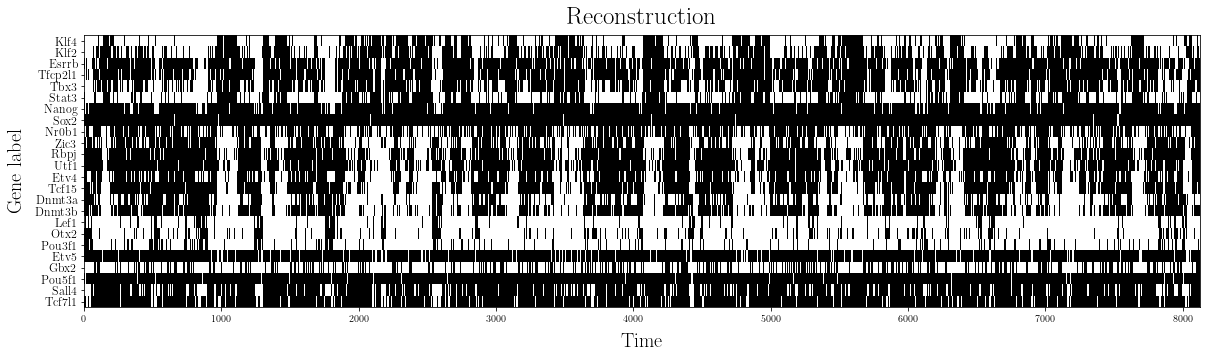

In [ ]:
#generate new data
spins_new_pN = model_pN_best.generate_samples()
fun_plotting.raster_plot(spins_new_pN, 'Reconstruction', 1,genes_order)
plt.show()

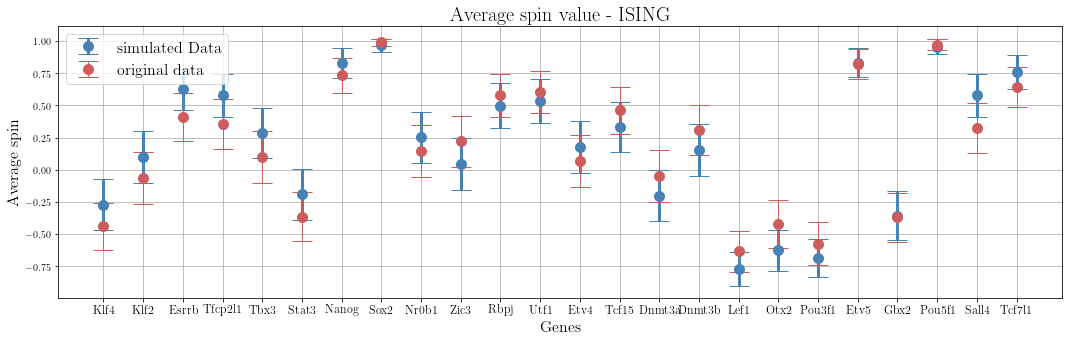

In [ ]:
plt.figure(figsize=(18,5))
plt.errorbar(genes_order, spins_new_pN.mean(axis=1), yerr=spins_new_pN.std(axis=1)/np.sqrt(24),  
             alpha=1, 
             fmt="o", ms = 10,
             elinewidth=3,
             color="steelblue",
             capsize=10,
             label= "simulated Data")

plt.errorbar(genes_order, spins_df_pN_mb_pst.mean(axis=1), yerr=spins_df_pN_mb_pst.std(axis=1)/np.sqrt(24), 
             alpha=1, 
             fmt="o", ms = 10,
             elinewidth=1,
             color="indianred",
             capsize=10,
             label = "original data")
plt.legend(loc="upper left", fontsize=16)
plt.xticks(fontsize=12)
plt.ylabel("Average spin", fontsize=16)
plt.xlabel("Genes", fontsize=16)
plt.title("Average spin value - ISING", fontsize=20)
plt.grid(True)

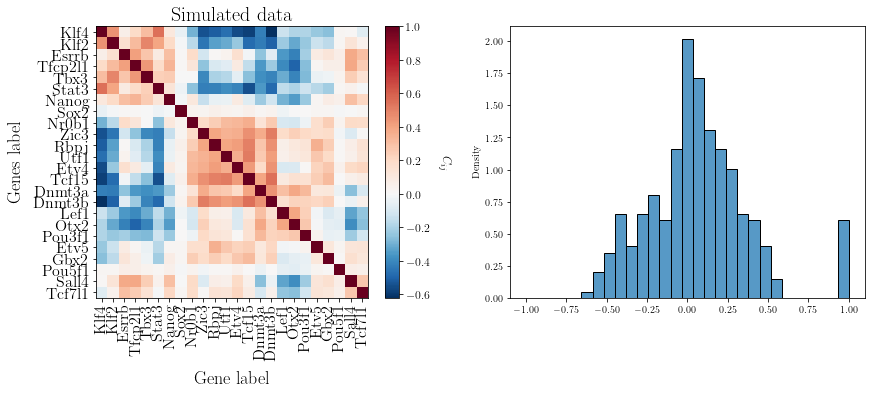

(array([], dtype=int64), array([], dtype=int64))


/var/folders/2z/hsgwjl3d49109llzgvkyf6jw0000gn/T/ipykernel_92205/3077192829.py:11: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  print(np.where(spins_new_lN==np.float("nan")))


In [ ]:
cm_sim = np.corrcoef(spins_new_pN)

bins = np.linspace(-1, 1, 30)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
figfunc.plotmat(cm_sim, fig, ax[0], genes_order, "Simulated data")
sns.histplot(np.ndarray.flatten(cm_sim), bins=bins,  ax=ax[1], stat="density")
plt.show()

# plt.imshow(np.corrcoef(spins_new_lN))
print(np.where(spins_new_lN==np.float("nan")))

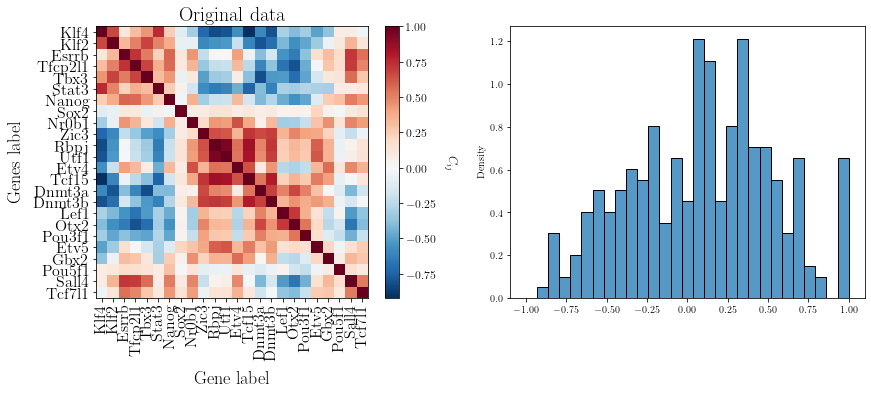

In [ ]:
cm_original = np.corrcoef(spins_df_pN_mb_pst)

bins = np.linspace(-1, 1, 30)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
figfunc.plotmat(cm_original, fig, ax[0], genes_order, "Original data")
sns.histplot(np.ndarray.flatten(cm_original), bins=bins,  ax=ax[1], stat="density")
plt.show()



In [ ]:
cm_orig_red = cm_original.copy()

cm_sim_red = cm_sim.copy()

# cm_sim_SCODE_red = np.loadtxt('cm_sim_SCODE_MB_PsiNorm.txt')


In [ ]:
corr_matxs_rnd_pN = np.array([np.corrcoef(spins_df_pN_mb_pst_shuffle[i,:,:]) for i in range(50)])


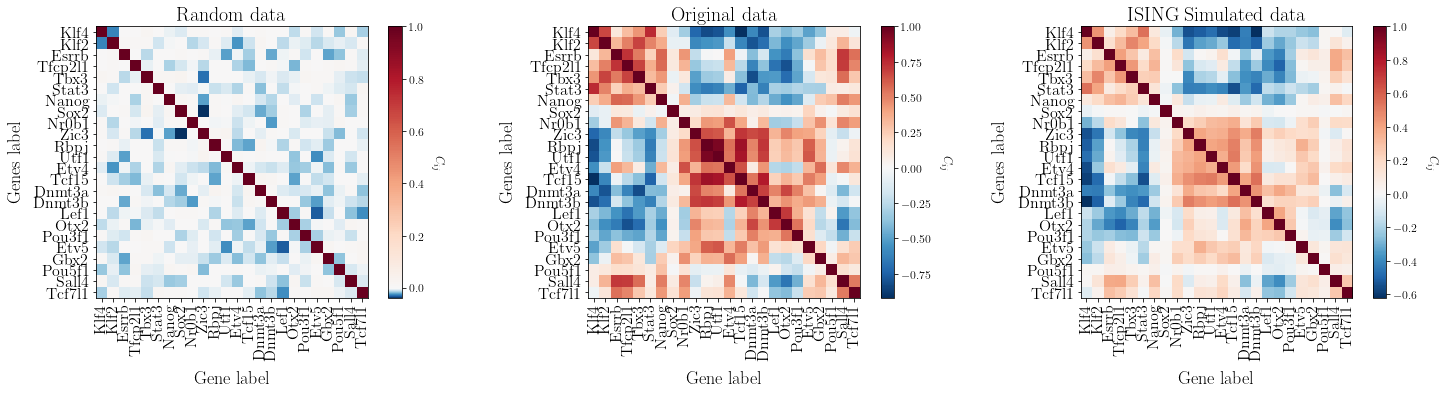

In [ ]:
genes_selected = genes_order.copy()

np.random.seed(1234)
cm_rnd = corr_matxs_rnd_pN[0,:,:]
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 5))
figfunc.plotmat(cm_rnd, fig, ax[0], genes_selected, "Random data", )
figfunc.plotmat(cm_orig_red, fig, ax[1], genes_selected, "Original data")
figfunc.plotmat(cm_sim_red, fig, ax[2], genes_selected, "ISING Simulated data")
# figfunc.plotmat(cm_sim_SCODE_red, fig, ax[3], genes_selected, "SCODE Simulated data")
plt.show()



In [ ]:
def sum_squared_abs_diff(array1, array2):
    diff = (array1.flatten()-array2.flatten())**2
    return np.sqrt(np.sum(diff))

In [ ]:
noise_dist = [sum_squared_abs_diff(cm_orig_red, corr_matxs_rnd_pN[i,:,:]) for i in range(50)]
noise_dist = np.mean(noise_dist)

result_IO = sum_squared_abs_diff(cm_orig_red, cm_sim_red) / noise_dist
print(f"Ising - Orig {result_IO:.2f}")

# result_SO = sum_squared_abs_diff(cm_orig_red, cm_sim_SCODE_red)/noise_dist
# print(f"Scode - Orig {result_SO:.2f}")

# restult_IS = sum_squared_abs_diff(cm_sim_red, cm_sim_SCODE_red)/noise_dist
# print(f"Scode - Ising {restult_IS:.2f}")

Ising - Orig 0.43


### Clustering

In [ ]:
# Perform linkage on your numpy array
Z = linkage(spins_new_pN.T, method='ward')


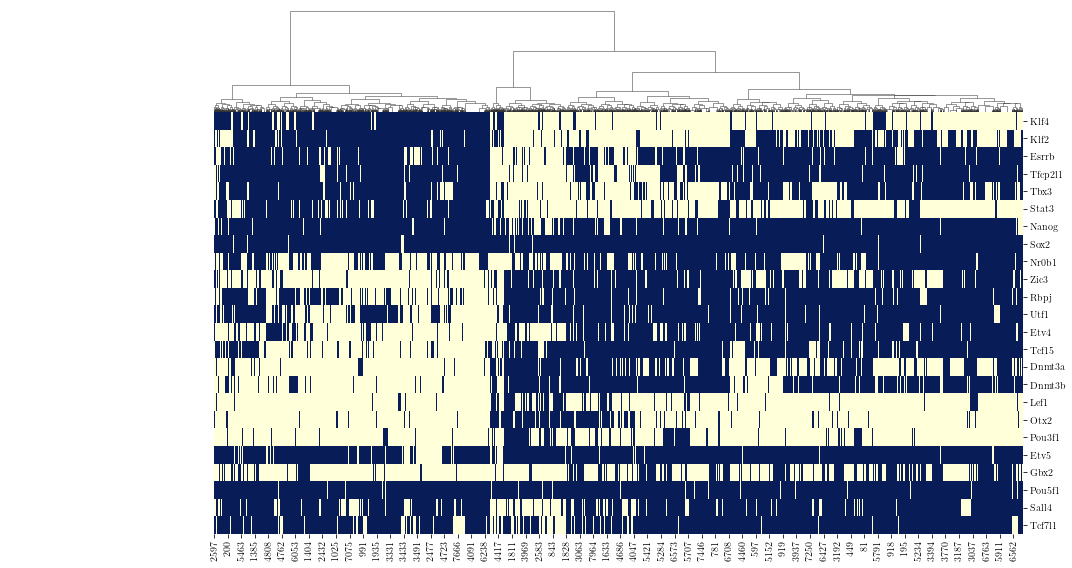

In [ ]:
# Plot the dendrogram and heatmap
sns.clustermap(spins_new_pN, col_linkage=Z, cmap='YlGnBu',yticklabels=genes_order,cbar=False, figsize=(15,8), row_cluster=False )
plt.xticks([])
plt.yticks([])
plt.show()


### Clustering on Original Data

In [ ]:
# Perform linkage on your numpy array
Z = linkage(spins_df_pN_mb_pst.T, method='ward')


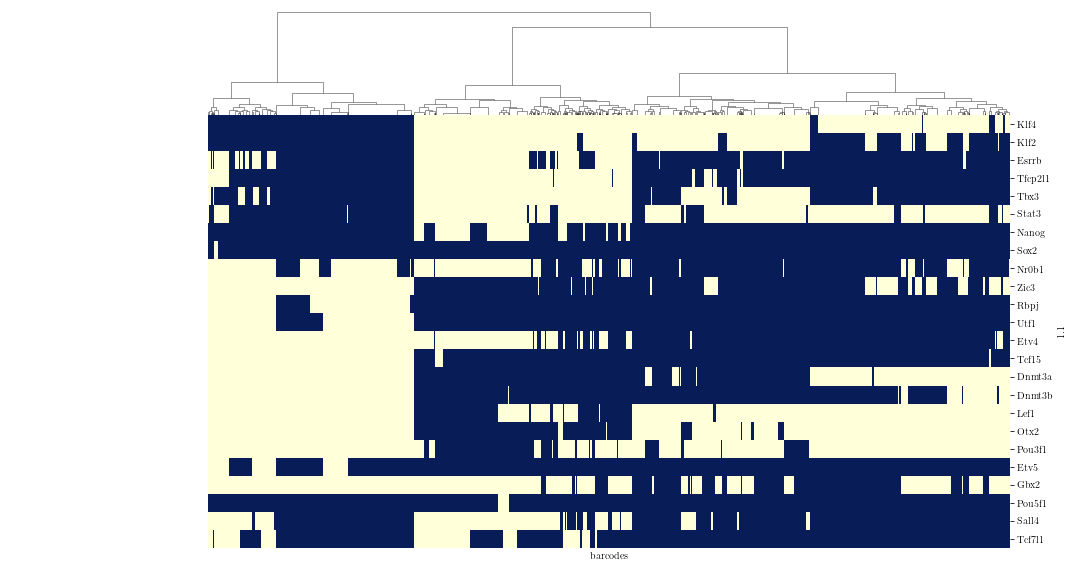

In [ ]:
# Plot the dendrogram and heatmap
sns.clustermap(spins_df_pN_mb_pst, col_linkage=Z, cmap='YlGnBu',
               yticklabels=genes_order, xticklabels=[],
               cbar=False, figsize=(15,8), row_cluster=False )

plt.xticks([])
plt.yticks([])

plt.show()


# Knock Out

In [ ]:
def info_KO(matx,model, KO_gene="Rbpj", genes_order=genes_order):
    """Remove the KO_gene from the interaction matrix and from the field"""
    KO_gene_idk = np.where(genes_order == KO_gene)[0]

    KO_rec_matx = np.delete(matx, KO_gene_idk, axis=0)
    KO_rec_matx = np.delete(KO_rec_matx, KO_gene_idk, axis=1)
    KO_rec_field = np.delete(model.h, KO_gene_idk, axis=0)
    KO_genes_order = np.delete(genes_order, KO_gene_idk, axis=0)
    return(KO_rec_matx, KO_rec_field, KO_gene_idk, KO_genes_order)

In [ ]:
def KO_plots_oneSim(model, matx, field, KO_genes_order, wt_avg, wt_std, seed=1, raster=True, avg=True):
    #generate new data
    KO_spins = model.generate_samples_SetData(matx=matx, field= field, seed=seed)
    if raster:
        fun_plotting.raster_plot(KO_spins, 'Reconstruction', 1, KO_genes_order)
        plt.show()
        
    if avg:
        # mean active time
        KO_std_spin = np.array(KO_spins.std(axis=1))
        KO_avg_spin = np.array(KO_spins.mean(axis=1))+1

        plt.figure(figsize=(18,5))
        plt.errorbar(KO_genes_order, KO_avg_spin, yerr=KO_std_spin/np.sqrt(len(wt_std)),  
                     alpha=1, 
                     fmt="o", ms = 10,
                     elinewidth=3,
                     color="steelblue",
                     capsize=10,
                     label= "simulated Data")

        plt.errorbar(KO_genes_order, wt_avg, yerr=wt_std/np.sqrt(len(wt_std)), 
                     alpha=1, 
                     fmt="o", ms = 10,
                     elinewidth=1,
                     color="indianred",
                     capsize=10,
                     label = "original data")
        plt.legend(loc="upper left", fontsize=16)
        plt.xticks(fontsize=12)
        plt.ylabel("Average spin", fontsize=16)
        plt.xlabel("Genes", fontsize=16)
        plt.title("Average spin values for each genes", fontsize=20)
        plt.grid(True)
        
def KO_plotLogFC_ExpAndSim(lofFC_Exp, logFC_Sim, KO_genes_order):
    plt.figure(figsize=(18,5))
    plt.plot(lofFC_Exp, 
             "o",ms = 10, label="Exp")
    plt.plot(logFC_Sim[:,0],  
             "o", ms = 10,
             color="darkred", label= "Sim")
    plt.xticks(np.arange(0,23),KO_genes_order)
    plt.axhline(0)
    plt.legend()

    


In [ ]:
def KO_logFC_sim(matx, field,genes_order,wt_avg, model, N_test=100):
    """Compute LogFC for SIMULATED data"""
    diff_sim = np.zeros((len(genes_order)-1, N_test_KO))
    for i in range(N_test_KO):
        KO_spins = model.generate_samples_SetData(matx=matx, field=field, seed=i*5)
        KO_avg_spin = np.array(KO_spins.mean(axis=1))+1
        KO_std_spin = np.array(KO_spins.std(axis=1))

        # Comparison
        diff_sim[:,i] = np.log2(KO_avg_spin/wt_avg)
    #     diff_sim = KO_pN_mb_pst_avg_spin-wt_pN_mb_pst_avg_spin
#         diff_sim_ii[np.abs(diff_sim_ii)<np.max(np.abs(diff_sim_ii))*thr_KO]=0    # set the threshold
#         diff_sim[:,i] = diff_sim_ii
    return(diff_sim)


def KO_comparison_ExpVsSim(lofFC_Exp, logFC_Sim, N_test=100):
    """compute the fraction of Experimental Data end Simulated data in Agreement"""
    comparison= np.array([np.sign(lofFC_Exp)*np.sign(logFC_Sim[:,ii]) for ii in range(N_test)])
#     print(np.sum([len(np.where(logFC_Sim[:,ii]==0)[0]) for ii in range(N_test)]))
    data_considered = np.array([len(np.where(comparison[ii,:]!=0)[0]) for ii in range(N_test)])
    
    in_agreement = np.array([len(np.where(comparison[ii,:]==1)[0])/data_considered[ii] for ii in range(N_test)])
    no_agreement = np.array([len(np.where(comparison[ii,:]==-1)[0])/data_considered[ii] for ii in range(N_test)])
    mean_in_agreement = np.mean(in_agreement)
    
    # Check
    check_sum = np.array([in_agreement[ii]+no_agreement[ii] for ii in range(N_test)])-1
    check = np.where(check_sum>0.001)[0]
    if check.size > 0:
        print("Error in comparison Exp and Sim")
    return(mean_in_agreement,    data_considered)

In [ ]:
N_test_KO = 500
thr_KO_Leeb = 0
thr_KO = thr_KO_Leeb

### Leeb data

In [ ]:
df_KO_N24_Leeb_cl = pd.read_csv(path_data+'Leeb_Data_Orig/df_KO_N24_cleaned.csv', index_col=0, header=0)

In [ ]:
df_KO_N24_Leeb_cl.head(2)

,Rbpj,Etv5,Tcf7l1
Klf4,2.890194,2.386695,0.00000
Klf2,0.000000,0.000000,2.33868


## PsiNorm

### KO Rbpj

/Users/cleliacorridori/Dropbox_2021 Dropbox/Jorah Mormont/GRN_Inference/CODE/lib/fun_asynch.py:135: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, F), array(float64, 1d, A))
  slist[:,idx+1] = asynch_glauber_dynamics(h, J, slist[:,idx], delta_t, gamma)


Fraction of agreement:  1.0
# of data Considered:  7.0


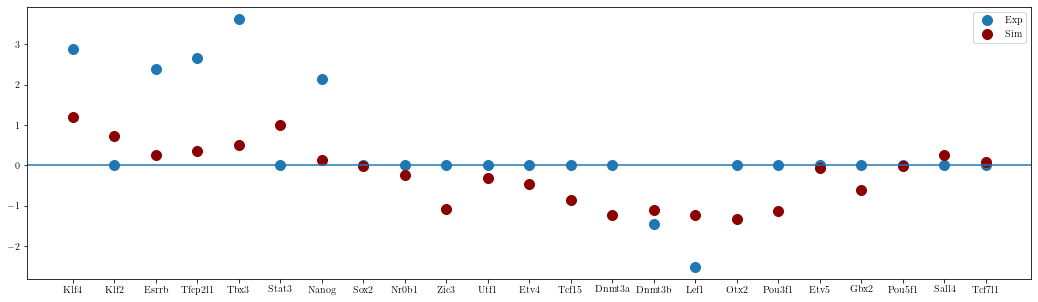

In [ ]:
# KO info
KO_gene = "Rbpj"
KO_pN_rec_matx, KO_pN_rec_field, KO_gene_idk, KO_genes_order = info_KO(pN_high_meanMatx, model_pN_best,"Rbpj",
                                                                               genes_order=genes_order)
# average activity for wt
wt_pN_mb_pst_avg_spin    = np.delete(np.array(spins_df_pN_mb_pst.mean(axis=1)),KO_gene_idk)+1

wt_pN_mb_pst_std_spin    = np.delete(np.array(spins_df_pN_mb_pst.std(axis=1)),KO_gene_idk)


#Compute LogFC
logFC_Leeb_R = np.delete(np.array(df_KO_N24_Leeb_cl[KO_gene]), KO_gene_idk) # logFC Leeb

logFC_Sim_R = KO_logFC_sim(KO_pN_rec_matx, KO_pN_rec_field, genes_order, 
                         wt_pN_mb_pst_avg_spin, model_pN_best,  N_test=N_test_KO)         # logFC Simulated (takes time)

KO_plotLogFC_ExpAndSim(logFC_Leeb_R, logFC_Sim_R, KO_genes_order)

# Fraction of LogFC in Agreement
mean_in_agreement_R, data_considered_R = KO_comparison_ExpVsSim(logFC_Leeb_R, logFC_Sim_R, N_test=N_test_KO)
print("Fraction of agreement: ", mean_in_agreement_R)
print("# of data Considered: ",data_considered_R.mean())


In [ ]:
# KO_plots_oneSim(model_pN_best, KO_pN_rec_matx, KO_pN_rec_field, KO_genes_order,
#                 wt_pN_mb_pst_avg_spin, wt_pN_mb_pst_std_spin,
#                 raster=True, avg=True)

### KO Etv5

Fraction of agreement:  0.9665238095238097
# of data Considered:  6.996


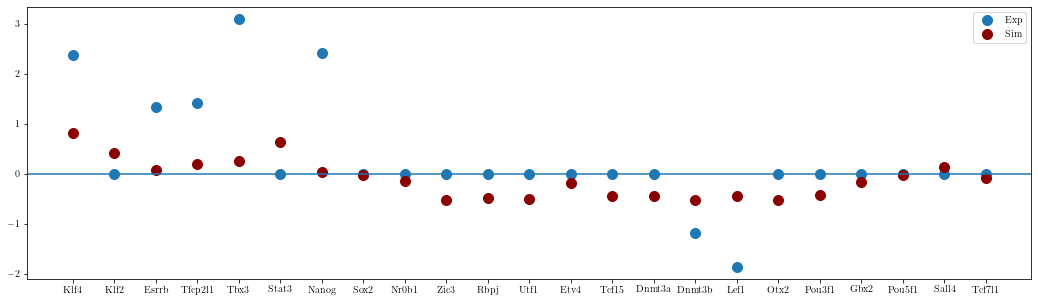

In [ ]:
# KO info
KO_gene = "Etv5"
KO_pN_rec_matx, KO_pN_rec_field, KO_gene_idk, KO_genes_order = info_KO(pN_high_meanMatx, model_pN_best, KO_gene,
                                                                               genes_order=genes_order)
# average activity for wt
wt_pN_mb_pst_avg_spin    = np.delete(np.array(spins_df_pN_mb_pst.mean(axis=1)),KO_gene_idk)+1

wt_pN_mb_pst_std_spin    = np.delete(np.array(spins_df_pN_mb_pst.std(axis=1)),KO_gene_idk)


#Compute LogFC
logFC_Leeb_E = np.delete(np.array(df_KO_N24_Leeb_cl[KO_gene]), KO_gene_idk) # logFC Leeb

logFC_Sim_E = KO_logFC_sim(KO_pN_rec_matx, KO_pN_rec_field, genes_order, 
                         wt_pN_mb_pst_avg_spin, model_pN_best, N_test=N_test_KO)         # logFC Simulated (takes time)

KO_plotLogFC_ExpAndSim(logFC_Leeb_E, logFC_Sim_E, KO_genes_order)

# Fraction of LogFC in Agreement
mean_in_agreement_E, data_considered_E = KO_comparison_ExpVsSim(logFC_Leeb_E, logFC_Sim_E, N_test=N_test_KO)
print("Fraction of agreement: ", mean_in_agreement_E)
print("# of data Considered: ",data_considered_E.mean())

In [ ]:
# KO_plots_oneSim(model_pN_best,KO_pN_rec_matx, KO_pN_rec_field, KO_genes_order,
#                 wt_pN_mb_pst_avg_spin, wt_pN_mb_pst_std_spin,
#                 raster=True, avg=True)

### KO Tcf7l1

Fraction of agreement:  0.2485333333333333
# of data Considered:  5.994


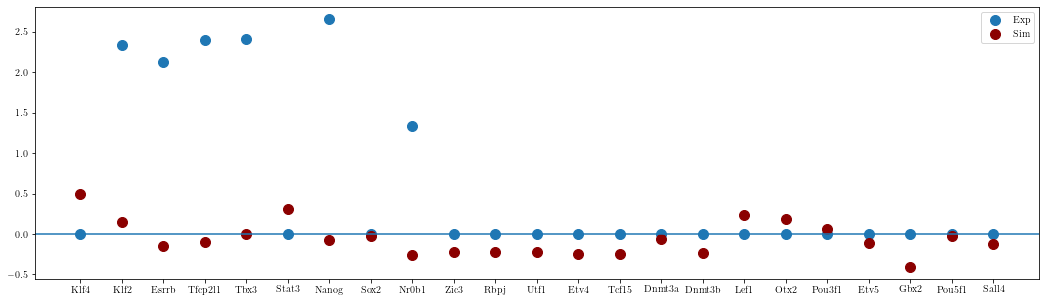

In [ ]:
# KO info
KO_gene = "Tcf7l1"
KO_pN_rec_matx, KO_pN_rec_field, KO_gene_idk, KO_genes_order = info_KO(pN_high_meanMatx, model_pN_best, KO_gene,
                                                                               genes_order=genes_order)
# average activity for wt
wt_pN_mb_pst_avg_spin    = np.delete(np.array(spins_df_pN_mb_pst.mean(axis=1)),KO_gene_idk)+1

wt_pN_mb_pst_std_spin    = np.delete(np.array(spins_df_pN_mb_pst.std(axis=1)),KO_gene_idk)


#Compute LogFC
logFC_Leeb_T = np.delete(np.array(df_KO_N24_Leeb_cl[KO_gene]), KO_gene_idk) # logFC Leeb

logFC_Sim_T = KO_logFC_sim(KO_pN_rec_matx, KO_pN_rec_field, genes_order, 
                         wt_pN_mb_pst_avg_spin, model_pN_best, N_test=N_test_KO)         # logFC Simulated (takes time)

KO_plotLogFC_ExpAndSim(logFC_Leeb_T, logFC_Sim_T, KO_genes_order)

# Fraction of LogFC in Agreement
mean_in_agreement_T, data_considered_T = KO_comparison_ExpVsSim(logFC_Leeb_T, logFC_Sim_T, N_test=N_test_KO)
print("Fraction of agreement: ", mean_in_agreement_T)
print("# of data Considered: ",data_considered_T.mean())

## LogNorm

### KO Rbpj

Fraction of agreement:  0.578190476190476
# of data Considered:  6.998


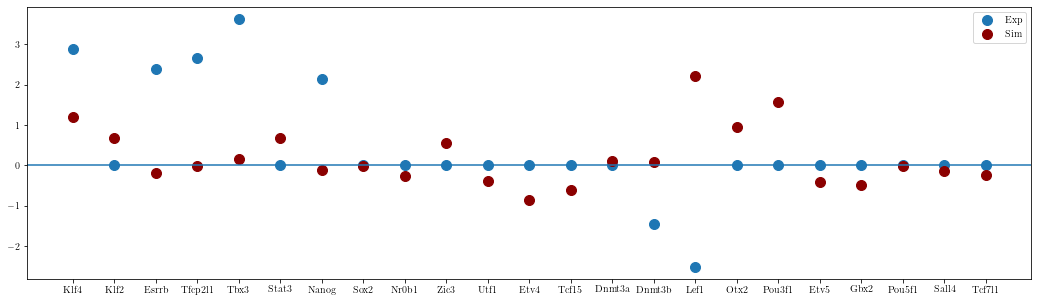

In [ ]:
# KO info
KO_gene = "Rbpj"
KO_lN_rec_matx, KO_lN_rec_field, KO_gene_idk, KO_genes_order = info_KO(lN_high_meanMatx, model_lN_best,KO_gene,
                                                                               genes_order=genes_order)
# average activity for wt
wt_lN_mb_pst_avg_spin    = np.delete(np.array(spins_df_lN_mb_pst.mean(axis=1)),KO_gene_idk)+1

wt_lN_mb_pst_std_spin    = np.delete(np.array(spins_df_lN_mb_pst.std(axis=1)),KO_gene_idk)


#Compute LogFC
logFC_Leeb_R = np.delete(np.array(df_KO_N24_Leeb_cl[KO_gene]), KO_gene_idk) # logFC Leeb

logFC_Sim_R = KO_logFC_sim(KO_lN_rec_matx, KO_lN_rec_field, genes_order, 
                         wt_lN_mb_pst_avg_spin,model_lN_best,  N_test=N_test_KO)         # logFC Simulated (takes time)

KO_plotLogFC_ExpAndSim(logFC_Leeb_R, logFC_Sim_R, KO_genes_order)

# Fraction of LogFC in Agreement
mean_in_agreement_R, data_considered_R = KO_comparison_ExpVsSim(logFC_Leeb_R, logFC_Sim_R, N_test=N_test_KO)
print("Fraction of agreement: ", mean_in_agreement_R)
print("# of data Considered: ",data_considered_R.mean())

### KO Etv5

Fraction of agreement:  0.8496190476190476
# of data Considered:  6.996


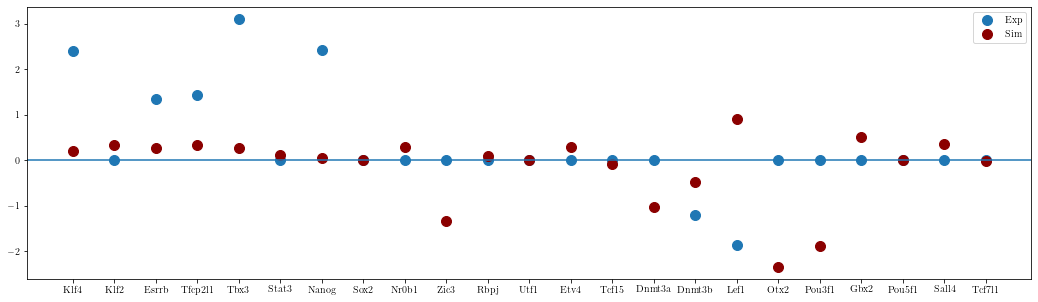

In [ ]:
KO_gene = "Etv5"
KO_lN_rec_matx, KO_lN_rec_field, KO_gene_idk, KO_genes_order = info_KO(lN_high_meanMatx, model_lN_best, KO_gene,
                                                                               genes_order=genes_order)
# average activity for wt
wt_lN_mb_pst_avg_spin    = np.delete(np.array(spins_df_lN_mb_pst.mean(axis=1)),KO_gene_idk)+1

wt_lN_mb_pst_std_spin    = np.delete(np.array(spins_df_lN_mb_pst.std(axis=1)),KO_gene_idk)


#Compute LogFC
logFC_Leeb_E = np.delete(np.array(df_KO_N24_Leeb_cl[KO_gene]), KO_gene_idk) # logFC Leeb

logFC_Sim_E = KO_logFC_sim(KO_lN_rec_matx, KO_lN_rec_field, genes_order, 
                         wt_lN_mb_pst_avg_spin,model_lN_best, N_test=N_test_KO)         # logFC Simulated (takes time)

KO_plotLogFC_ExpAndSim(logFC_Leeb_E, logFC_Sim_E, KO_genes_order)

# Fraction of LogFC in Agreement
mean_in_agreement_E, data_considered_E = KO_comparison_ExpVsSim(logFC_Leeb_E, logFC_Sim_E, N_test=N_test_KO)
print("Fraction of agreement: ", mean_in_agreement_E)
print("# of data Considered: ",data_considered_E.mean())


### KO Tcf7l1

Fraction of agreement:  0.0003333333333333333
# of data Considered:  6.0


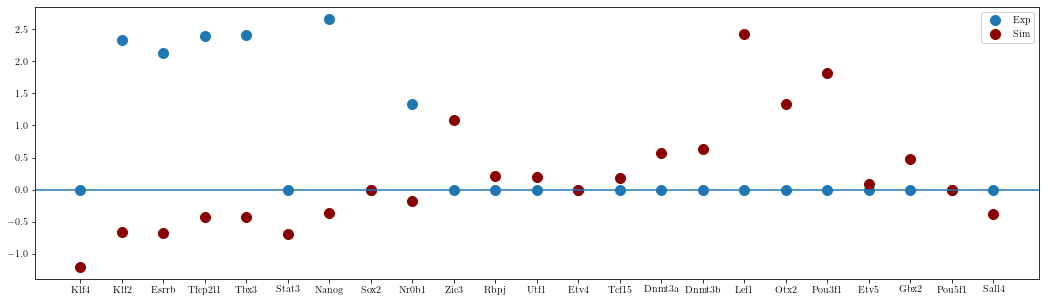

In [ ]:
KO_gene = "Tcf7l1"

KO_lN_rec_matx, KO_lN_rec_field, KO_gene_idk, KO_genes_order = info_KO(lN_high_meanMatx, model_lN_best, KO_gene,
                                                                               genes_order=genes_order)
# average activity for wt
wt_lN_mb_pst_avg_spin    = np.delete(np.array(spins_df_lN_mb_pst.mean(axis=1)),KO_gene_idk)+1

wt_lN_mb_pst_std_spin    = np.delete(np.array(spins_df_lN_mb_pst.std(axis=1)),KO_gene_idk)


#Compute LogFC
logFC_Leeb_T = np.delete(np.array(df_KO_N24_Leeb_cl[KO_gene]), KO_gene_idk) # logFC Leeb

logFC_Sim_T = KO_logFC_sim(KO_lN_rec_matx, KO_lN_rec_field, genes_order, 
                         wt_lN_mb_pst_avg_spin, model_lN_best, N_test=N_test_KO)         # logFC Simulated (takes time)

KO_plotLogFC_ExpAndSim(logFC_Leeb_T, logFC_Sim_T, KO_genes_order)

# Fraction of LogFC in Agreement
mean_in_agreement_T, data_considered_T = KO_comparison_ExpVsSim(logFC_Leeb_T, logFC_Sim_T, N_test=N_test_KO)
print("Fraction of agreement: ", mean_in_agreement_T)
print("# of data Considered: ",data_considered_T.mean())




# Implementation for reshuffled data

In [ ]:
Ntrials = 50 # on the parameters
Ntest   = 50 # on the datasets
compute = False

if compute:
    pN_matx_sel_rnd = np.zeros((Ntest, Ntrials, len(genes_order), len(genes_order)))
    lN_matx_sel_rnd = np.zeros((Ntest, Ntrials, len(genes_order), len(genes_order)))

    pN_prec_sel_rnd = np.zeros((Ntest, Ntrials))
    lN_prec_sel_rnd = np.zeros((Ntest, Ntrials))

    pN_int_val_rnd  = np.zeros((4, len(TPtrial_list), Ntrials, Ntest))
    lN_int_val_rnd  = np.zeros((4, len(TPtrial_list), Ntrials, Ntest))

    for ii in range(Ntest):
        print("\n Testing Sample "+str(ii+1))
        pN_matx_sel_rnd[ii,:,:,:], pN_prec_sel_rnd[ii, :], pN_int_val_rnd[:, :, :, ii] = grid_search(np.array(spins_df_pN_mb_pst_shuffle[ii,:,:]), 
                                                                                                        params, TPtrial_list, genes_order,
                                                                                                        Ntrials = Ntrials)
        lN_matx_sel_rnd[ii,:,:,:],  lN_prec_sel_rnd[ii, :],  lN_int_val_rnd[:, :, :, ii]  = grid_search(np.array(spins_df_lN_mb_pst_shuffle[ii,:,:]), 
                                                                                                        params, TPtrial_list, genes_order,
                                                                                                        Ntrials = Ntrials)
else:
    # LOADING the data
    pN_arrays_rnd = np.load('OUT_ISING/PsiNORM/pN_arrays_pst_MB_RND_23_1_23.npz')
    pN_matx_sel_rnd = pN_arrays_rnd['array_1']
    pN_prec_sel_rnd = pN_arrays_rnd['array_2']
    pN_int_val_rnd =  pN_arrays_rnd['array_3']
    
    lN_arrays_rnd = np.load('OUT_ISING/LogNORM/lN_arrays_pst_MB_RND_23_1_23.npz')
    lN_matx_sel_rnd = lN_arrays_rnd['array_1']
    lN_prec_sel_rnd = lN_arrays_rnd['array_2']
    lN_int_val_rnd = lN_arrays_rnd['array_3']

## Result

### TP fraction analysis

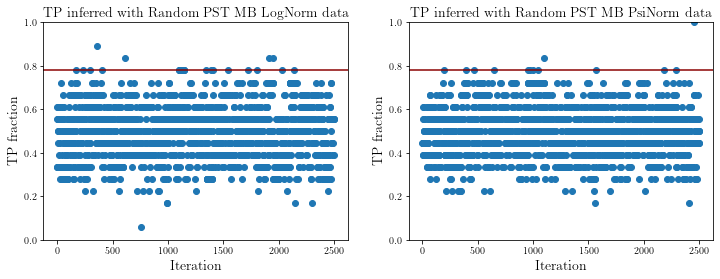

In [ ]:
# Vector containing ALL the interactions from shuffled data

# Plot the TP fraction
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(lN_prec_sel_rnd.flatten(), 'o')
ax[1].plot(pN_prec_sel_rnd.flatten(), 'o')

# Add labels and a title & Co
ax[0].set_xlabel('Iteration', fontsize=14)
ax[0].set_ylabel('TP fraction', fontsize=14)
ax[0].set_title('TP inferred with Random PST MB LogNorm data', fontsize=14)
ax[1].set_xlabel('Iteration', fontsize=14)
ax[1].set_ylabel('TP fraction', fontsize=14)
ax[1].set_title('TP inferred with Random PST MB PsiNorm data', fontsize=14)

ax[0].set_ylim([0,1])
ax[0].axhline(0.78, color="darkred")
ax[1].set_ylim([0,1])
ax[1].axhline(0.78, color="darkred")

plt.show()


[0.33333333 0.5        0.72222222]


/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


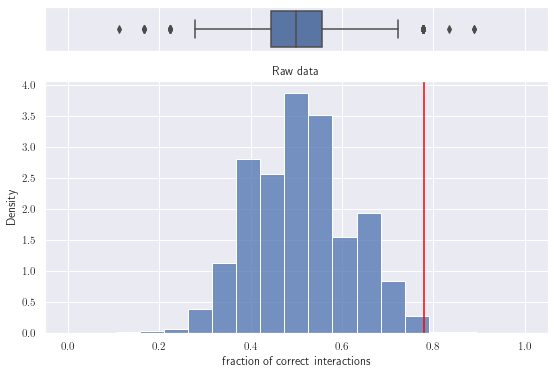

In [ ]:
# quartiles of ALL the random interactions
print(np.quantile(raw_prec_sel_rnd.flatten(),[0.05, 0.5, 0.95]))

sns.set(style="darkgrid")
 
# creating the figure containing the distribution and the box plot
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(9, 6))
 
# assigning a graph to each ax
sns.boxplot(raw_prec_sel_rnd.flatten(), ax=ax_box)
sns.histplot(raw_prec_sel_rnd.flatten(), ax=ax_hist, stat="density", bins=19, binrange = (0,1))
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_hist.set(xlabel='fraction of correct interactions')
plt.axvline(x = 0.78, color = 'red', label = 'axvline - full height')
plt.title("Raw data")
plt.show()

sns.set_style("whitegrid")

[0.27777778 0.5        0.72222222]


/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


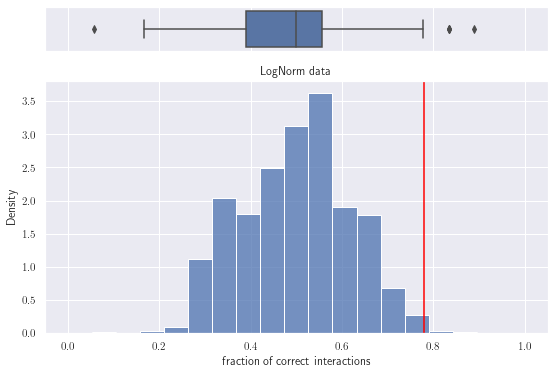

In [ ]:
# quartiles of ALL the random interactions
print(np.quantile(lN_prec_sel_rnd.flatten(),[0.05, 0.5, 0.95]))

sns.set(style="darkgrid")
 
# creating the figure containing the distribution and the box plot
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(9, 6))
 
# assigning a graph to each ax
sns.boxplot(lN_prec_sel_rnd.flatten(), ax=ax_box)
sns.histplot(lN_prec_sel_rnd.flatten(), ax=ax_hist, stat="density", bins=19, binrange = (0,1))
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_hist.set(xlabel='fraction of correct interactions')
plt.axvline(x = 0.78, color = 'red', label = 'axvline - full height')
plt.title("LogNorm data")
plt.show()

sns.set_style("whitegrid")

### Interaction distribution

quantiles [-0.02  0.    0.02]


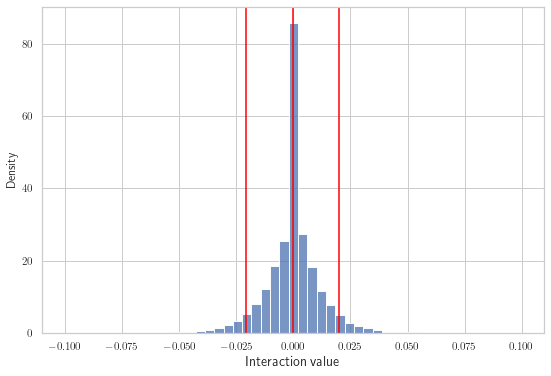

In [ ]:
raw_ints_rnd_all = raw_matx_sel_rnd.flatten()

plt.figure(figsize=(9,6))
bins = np.linspace(-0.1,0.1,50)
sns.histplot(raw_ints_rnd_all, bins=bins, stat="density")

plt.xlabel(xlabel='Interaction value', fontsize=14)
plt.axvline(x = np.quantile(raw_ints_rnd_all,[0.05, 0.5, 0.95])[0], color = 'red', label = 'axvline - full height')
plt.axvline(x = np.quantile(raw_ints_rnd_all,[0.05, 0.5, 0.95])[1], color = 'red', label = 'axvline - full height')
plt.axvline(x = np.quantile(raw_ints_rnd_all,[0.05, 0.5, 0.95])[2], color = 'red', label = 'axvline - full height')



print("quantiles", np.round(np.quantile(raw_ints_rnd_all,[0.05, 0.5, 0.95]),2))


quantiles [-0.02   0.     0.022]


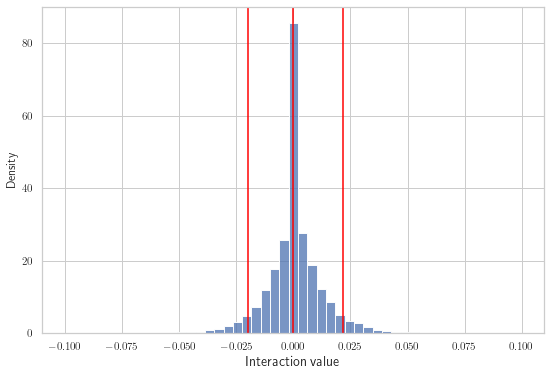

In [ ]:
lN_ints_rnd_all = lN_matx_sel_rnd.flatten()

plt.figure(figsize=(9,6))
bins = np.linspace(-0.1,0.1,50)
sns.histplot(lN_ints_rnd_all, bins=bins, stat="density")

plt.xlabel(xlabel='Interaction value', fontsize=14)
plt.axvline(x = np.quantile(lN_ints_rnd_all,[0.05, 0.5, 0.95])[0], color = 'red', label = 'axvline - full height')
plt.axvline(x = np.quantile(lN_ints_rnd_all,[0.05, 0.5, 0.95])[1], color = 'red', label = 'axvline - full height')
plt.axvline(x = np.quantile(lN_ints_rnd_all,[0.05, 0.5, 0.95])[2], color = 'red', label = 'axvline - full height')

print("quantiles", np.round(np.quantile(lN_ints_rnd_all,[0.05, 0.5, 0.95]),3))


### Setting the TP threshold based on data

#### Random data

Number of test*trial TP frac: (4, 18, 2500)
[0.         0.         0.33333333]


/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


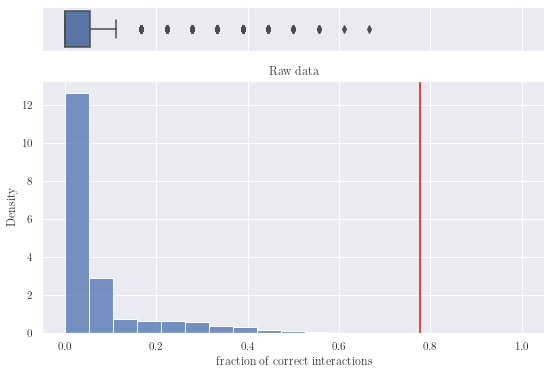

TP fraction for Raw data:  0.7777777777777778


In [ ]:
# print(raw_matx_sel_rnd.shape, raw_prec_sel_rnd.shape, raw_int_val_rnd.shape )
raw_int_val_rnd_all = raw_int_val_rnd.reshape((4,18,50*50))
print("Number of test*trial TP frac:", raw_int_val_rnd_all.shape)

raw_TPfrac_thr = np.zeros(raw_int_val_rnd_all.shape[2])
for kk in range(raw_int_val_rnd_all.shape[2]):
    raw_TPfrac_thr[kk]= len(np.where(np.abs(raw_int_val_rnd_all[2,:,kk]*raw_int_val_rnd_all[3,:,kk])>0.02)[0])/len(raw_int_val_rnd_all[2,:,kk])
    
# quartiles of ALL the random interactions
print(np.quantile(raw_TPfrac_thr,[0.05, 0.5, 0.95]))

sns.set(style="darkgrid")
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)
# creating the figure containing the distribution and the box plot
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(9, 6))
 
# assigning a graph to each ax
sns.boxplot(raw_TPfrac_thr, ax=ax_box)
sns.histplot(raw_TPfrac_thr, ax=ax_hist, stat="density", bins=19, binrange = (0,1))
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_hist.set(xlabel='fraction of correct interactions')
raw_TP_true_thr = len(np.where(np.abs(raw_Mean_info_int[2,:]*raw_Mean_info_int[3,:])>0.02)[0])/18
plt.axvline(x = raw_TP_true_thr, color = 'red', label = 'axvline - full height')
plt.title("Raw data")
plt.show()

sns.set_style("white")   

print("TP fraction for Raw data: ", raw_TP_true_thr)

    

Number of test*trial TP frac: (4, 18, 2500)
[0.         0.         0.33333333]

/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


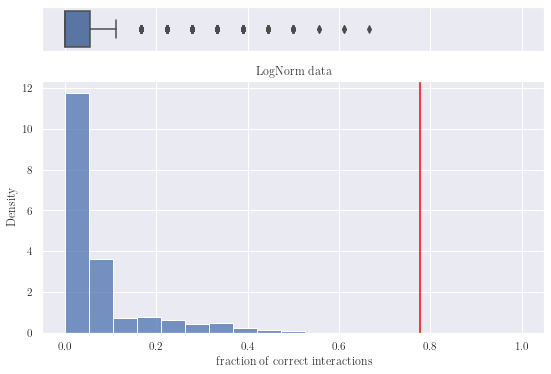

TP fraction for LogNorm data:  0.7777777777777778


In [ ]:
# print(lN_matx_sel_rnd.shape, lN_prec_sel_rnd.shape, lN_int_val_rnd.shape )
lN_int_val_rnd_all = lN_int_val_rnd.reshape((4,18,50*50))
print("Number of test*trial TP frac:", lN_int_val_rnd_all.shape)

lN_TPfrac_thr = np.zeros(lN_int_val_rnd_all.shape[2])
for kk in range(lN_int_val_rnd_all.shape[2]):
    lN_TPfrac_thr[kk]= len(np.where(np.abs(lN_int_val_rnd_all[2,:,kk]*lN_int_val_rnd_all[3,:,kk])>0.02)[0])/len(lN_int_val_rnd_all[2,:,kk])
    
# quartiles of ALL the random interactions
print(np.quantile(lN_TPfrac_thr,[0.05, 0.5, 0.95]))


# plot setting
sns.set(style="darkgrid")
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(9, 6))
# plot
sns.boxplot(lN_TPfrac_thr, ax=ax_box)
sns.histplot(lN_TPfrac_thr, ax=ax_hist, stat="density", bins=19, binrange = (0,1))
# other plot stuff
ax_box.set(xlabel='')
ax_hist.set(xlabel='fraction of correct interactions')

lN_TP_true_thr = len(np.where(np.abs(lN_Mean_info_int[2,:]*lN_Mean_info_int[3,:])>0.02)[0])/18
plt.axvline(x = lN_TP_true_thr, color = 'red', label = 'axvline - full height')
plt.title("LogNorm data")
plt.show()

# reset of the plot style
sns.set_style("white")    

print("TP fraction for LogNorm data: ", lN_TP_true_thr)
    

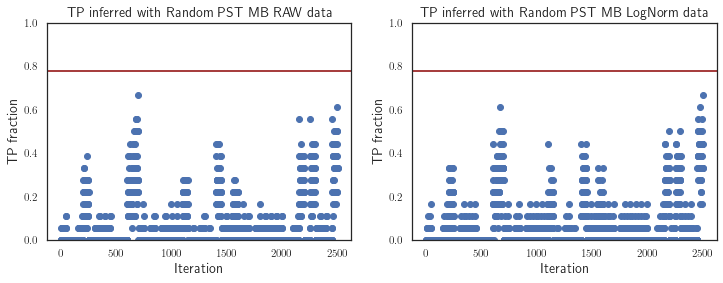

In [ ]:
# Vector containing ALL the interactions from shuffled data
# Plot the TP fraction
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(raw_TPfrac_thr.flatten(), 'o')
ax[1].plot(lN_TPfrac_thr.flatten(), 'o')

# Add labels and a title & Co
ax[0].set_xlabel('Iteration', fontsize=14)
ax[0].set_ylabel('TP fraction', fontsize=14)
ax[0].set_title('TP inferred with Random PST MB RAW data', fontsize=14)
ax[1].set_xlabel('Iteration', fontsize=14)
ax[1].set_ylabel('TP fraction', fontsize=14)
ax[1].set_title('TP inferred with Random PST MB LogNorm data', fontsize=14)

ax[0].set_ylim([0,1])
ax[0].axhline(0.78, color="darkred")
ax[1].set_ylim([0,1])
ax[1].axhline(0.78, color="darkred")

plt.show()

#### True data

Index of the model that satisfied the condition,  96
[0.27777778 0.5        0.55555556]


/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


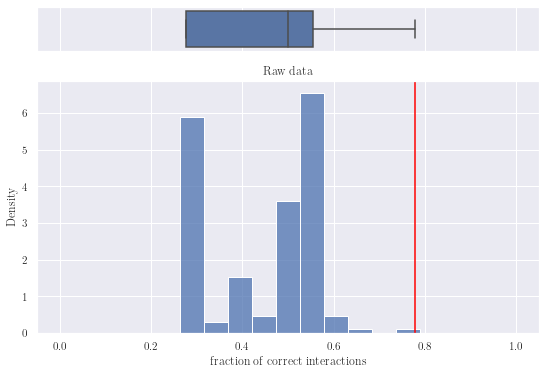

TP fraction for Raw data: 0.78


In [ ]:
raw_TPfrac_thr_true = np.zeros(raw_int_val_true.shape[2])
raw_idx_TPhigh_true = []
for kk in range(raw_int_val_true.shape[2]):
    raw_TPfrac_thr_true[kk]= len(np.where(np.abs(raw_int_val_true[2,:,kk]*raw_int_val_true[3,:,kk])>0.02)[0])/len(raw_int_val_true[2,:,kk])
    if raw_TPfrac_thr_true[kk]>=0.75:
        print("Index of the model that satisfied the condition, ", kk)
        raw_idx_TPhigh_true.append(kk)
        
    
# quartiles of ALL the random interactions
print(np.quantile(raw_TPfrac_thr_true,[0.05, 0.5, 0.95]))

sns.set(style="darkgrid")
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)
# creating the figure containing the distribution and the box plot
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(9, 6))
 
# assigning a graph to each ax
sns.boxplot(raw_TPfrac_thr_true, ax=ax_box)
sns.histplot(raw_TPfrac_thr_true, ax=ax_hist, stat="density", bins=19, binrange = (0,1))
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_hist.set(xlabel='fraction of correct interactions')
raw_TP_true_thr = len(np.where(np.abs(raw_Mean_info_int[2,:]*raw_Mean_info_int[3,:])>0.02)[0])/18
plt.axvline(x = raw_TP_true_thr, color = 'red', label = 'axvline - full height')
plt.title("Raw data")
plt.show()

sns.set_style("white")   

print(f"TP fraction for Raw data: {raw_TP_true_thr:.2f}")

    

Index of the model that satisfied the condition,  31
[0.22222222 0.55555556 0.66666667]


/Users/cleliacorridori/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


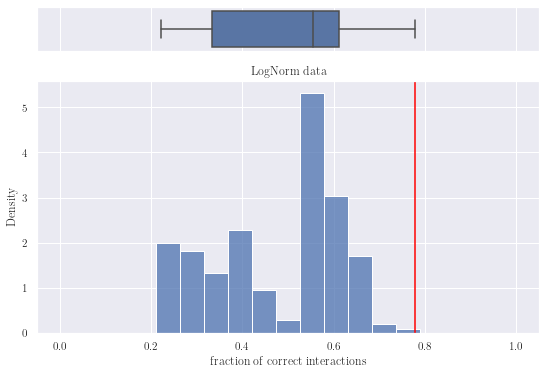

TP fraction for LogNorm data: 0.78


In [ ]:
lN_TPfrac_thr_true = np.zeros(lN_int_val_true.shape[2])
lN_idx_TPhigh_true = []
for kk in range(lN_int_val_true.shape[2]):
    lN_TPfrac_thr_true[kk]= len(np.where(np.abs(lN_int_val_true[2,:,kk]*lN_int_val_true[3,:,kk])>0.02)[0])/len(lN_int_val_true[2,:,kk])
    if lN_TPfrac_thr_true[kk]>=0.75:
        print("Index of the model that satisfied the condition, ", kk)
        lN_idx_TPhigh_true.append(kk)
        
    
# quartiles of ALL the random interactions
print(np.quantile(lN_TPfrac_thr_true,[0.05, 0.5, 0.95]))

sns.set(style="darkgrid")
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=True)
# creating the figure containing the distribution and the box plot
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(9, 6))
 
# assigning a graph to each ax
sns.boxplot(lN_TPfrac_thr_true, ax=ax_box)
sns.histplot(lN_TPfrac_thr_true, ax=ax_hist, stat="density", bins=19, binrange = (0,1))
 
# Remove x axis name for the boxplot
ax_box.set(xlabel='')
ax_hist.set(xlabel='fraction of correct interactions')
lN_TP_true_thr = len(np.where(np.abs(lN_Mean_info_int[2,:]*lN_Mean_info_int[3,:])>0.02)[0])/18
plt.axvline(x = lN_TP_true_thr, color = 'red', label = 'axvline - full height')
plt.title("LogNorm data")
plt.show()

sns.set_style("white")   

# print("TP fraction for lN data: ", lN_TP_true_thr)
print(f"TP fraction for LogNorm data: {lN_TP_true_thr:.2f}")


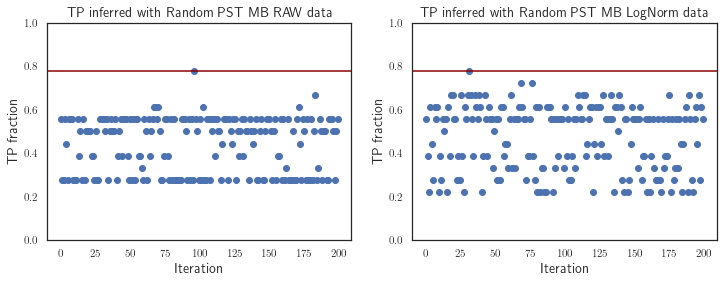

In [ ]:
# Plot the TP fraction
fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].plot(raw_TPfrac_thr_true.flatten(), 'o')
ax[1].plot(lN_TPfrac_thr_true.flatten(), 'o')

# Add labels and a title & Co
ax[0].set_xlabel('Iteration', fontsize=14)
ax[0].set_ylabel('TP fraction', fontsize=14)
ax[0].set_title('TP inferred with Random PST MB RAW data', fontsize=14)
ax[1].set_xlabel('Iteration', fontsize=14)
ax[1].set_ylabel('TP fraction', fontsize=14)
ax[1].set_title('TP inferred with Random PST MB LogNorm data', fontsize=14)

ax[0].set_ylim([0,1])
ax[0].axhline(0.78, color="darkred")
ax[1].set_ylim([0,1])
ax[1].axhline(0.78, color="darkred")

plt.show()


### ERR: Setting the TP threshold based on Interactions Normalization

In [ ]:
# # print(raw_matx_sel_rnd.shape, raw_prec_sel_rnd.shape, raw_int_val_rnd.shape )
# raw_int_val_rnd_all = raw_int_val_rnd.reshape((4,18,50*50))
# raw_matx_sel_rnd_all = raw_matx_sel_rnd.reshape((50*50,24,24))
# print("Number of test*trial TP frac:", raw_int_val_rnd_all.shape)

# raw_TPfrac_thrPerc = np.zeros(raw_int_val_rnd_all.shape[2])
# for kk in range(raw_int_val_rnd_all.shape[2]):
#     raw_int_rnd_max = np.abs(raw_matx_sel_rnd_all[kk,:,:]).max()
#     raw_TPfrac_thrPerc[kk]= len(np.where(np.abs(raw_int_val_rnd_all[2,:,kk]*raw_int_val_rnd_all[3,:,kk]/raw_int_rnd_max)>0.01)[0])/len(raw_int_val_rnd_all[2,:,kk])
    
# # quartiles of ALL the random interactions
# print(np.quantile(raw_TPfrac_thrPerc,[0.05, 0.5, 0.95]))

# sns.set(style="darkgrid")
# matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# matplotlib.rc('text', usetex=True)
# # creating the figure containing the distribution and the box plot
# f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(9, 6))
 
# # assigning a graph to each ax
# sns.boxplot(raw_TPfrac_thrPerc, ax=ax_box)
# sns.histplot(raw_TPfrac_thrPerc, ax=ax_hist, stat="density", bins=19, binrange = (0,1))
 
# # Remove x axis name for the boxplot
# ax_box.set(xlabel='')
# ax_hist.set(xlabel='fraction of correct interactions')
# raw_TP_true_thr = len(np.where(np.abs(raw_Mean_info_int[2,:]*raw_Mean_info_int[3,:])>0.02)[0])/18
# plt.axvline(x = raw_TP_true_thr, color = 'red', label = 'axvline - full height')
# plt.title("Raw data")
# plt.show()

# sns.set_style("white")   

# print("TP fraction for Raw data: ", raw_TP_true_thr)

    

In [ ]:
# # print(lN_matx_sel_rnd.shape, lN_prec_sel_rnd.shape, lN_int_val_rnd.shape )
# lN_int_val_rnd_all = lN_int_val_rnd.reshape((4,18,50*50))
# lN_matx_sel_rnd_all = lN_matx_sel_rnd.reshape((50*50,24,24))
# print("Number of test*trial TP frac:", lN_int_val_rnd_all.shape)

# lN_TPfrac_thrPerc = np.zeros(lN_int_val_rnd_all.shape[2])
# for kk in range(lN_int_val_rnd_all.shape[2]):
#     lN_int_rnd_max = np.abs(lN_matx_sel_rnd_all[kk,:,:]).max()
#     lN_TPfrac_thrPerc[kk]= len(np.where(np.abs(lN_int_val_rnd_all[2,:,kk]*lN_int_val_rnd_all[3,:,kk]/lN_int_rnd_max)>0.01)[0])/len(lN_int_val_rnd_all[2,:,kk])
    
# # quartiles of ALL the random interactions
# print(np.quantile(lN_TPfrac_thrPerc,[0.05, 0.5, 0.95]))

# sns.set(style="darkgrid")
# matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
# matplotlib.rc('text', usetex=True)
# # creating the figure containing the distribution and the box plot
# f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.15, .85)}, figsize=(9, 6))
 
# # assigning a graph to each ax
# sns.boxplot(lN_TPfrac_thrPerc, ax=ax_box)
# sns.histplot(lN_TPfrac_thrPerc, ax=ax_hist, stat="density", bins=19, binrange = (0,1))
 
# # Remove x axis name for the boxplot
# ax_box.set(xlabel='')
# ax_hist.set(xlabel='fraction of correct interactions')
# lN_TP_true_thr = len(np.where(np.abs(lN_Mean_info_int[2,:]*lN_Mean_info_int[3,:])>0.02)[0])/18
# plt.axvline(x = lN_TP_true_thr, color = 'red', label = 'axvline - full height')
# plt.title("LogNorm data")
# plt.show()

# sns.set_style("white")   

# print("TP fraction for LogNorm data: ", lN_TP_true_thr)

    

### Distibutions of known interactions

In [ ]:
def TP_distribution(interaction_list, interaction_matrices, genes_list):

    int_val = np.zeros((len(interaction_list), interaction_matrices.shape[0]))
    for ii in range(len(interaction_list)):
        couple = interaction_list[ii].split(" ")
        gene1_idx = np.where(genes_list == couple[1])[0] #idx of gene 1
        gene0_idx = np.where(genes_list == couple[0])[0] #idx of gene 0        
            
        # Get the interaction value and the sign of the interaction
        int_val[ii,:] = interaction_matrices[:,gene1_idx[0], gene0_idx[0]]


    return(int_val)
        

IN random:  Nanog Pou3f1 -1
number of ints values far from the distribution:  17


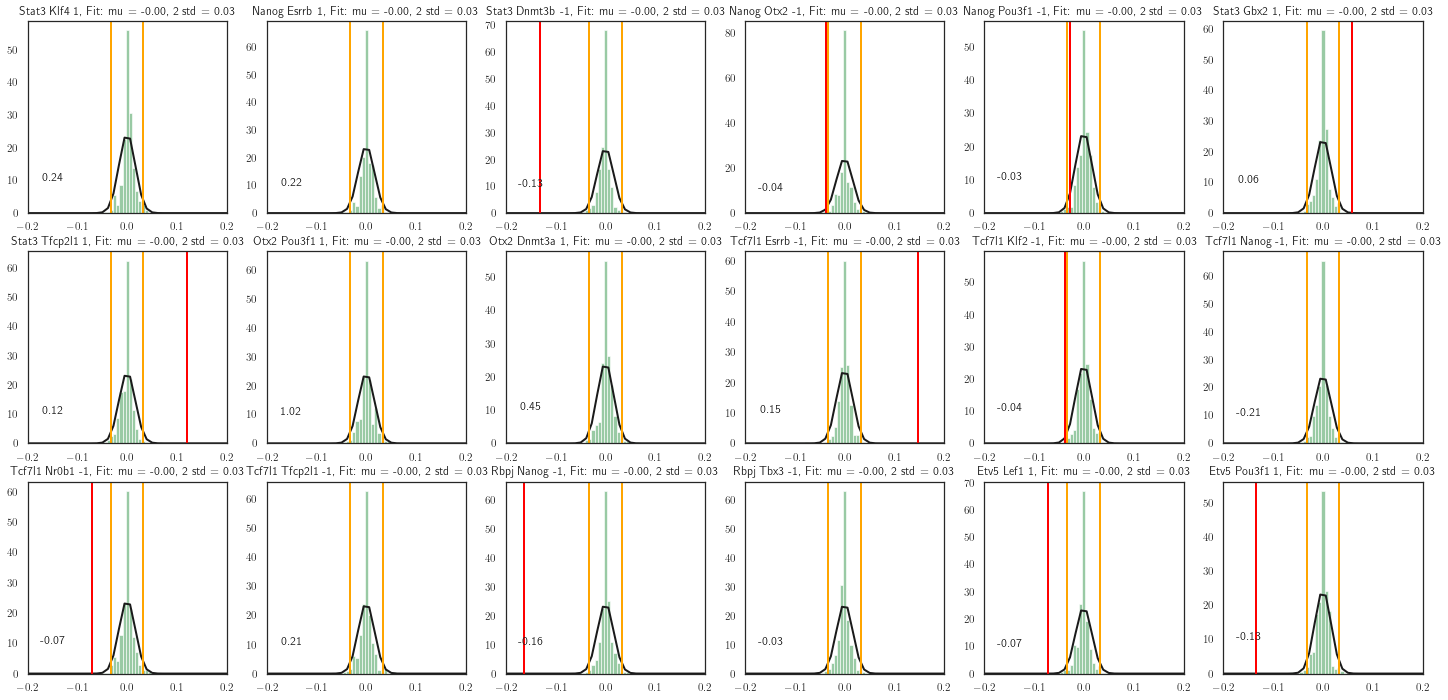

In [ ]:
raw_matx_sel_rnd_all = raw_matx_sel_rnd.reshape((50*50,24,24))

interactions_shuffled = TP_distribution(TPtrial_list, raw_matx_sel_rnd_all, genes_order)
interactions_shuffled.shape

check = len(TPtrial_list)

# Create a figure with 3 columns and 6 rows
fig, axs = plt.subplots(3, 6, figsize=(25, 12))

# Iterate over the rows and columns of the subplot
for ii in range(raw_Mean_info_int.shape[1]):
    # Get the axis object for the current subplot
    ax = axs[ii // 6, ii % 6]
    
    # Plot the histogram
    bins_thr = 0.15
    bins= np.linspace(-bins_thr-0.1, bins_thr+0.1, 80)
    nn, _,_ = ax.hist(interactions_shuffled[ii,:], bins=bins, density=True, alpha=0.6, color='g')
    mu, std = norm.fit(interactions_shuffled)
    ax.set_xlim([-bins_thr-0.4, bins_thr+0.4])

    # Plot the PDF
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, 'k', linewidth=2)
    ax.axvline(x=raw_Mean_info_int[2,ii], color="red", lw=2)
    std_range=2
    title = TPtrial_list[ii]+", Fit: mu = %.2f,  %.f std = %.2f" % (mu, std_range, std_range*std)
    ax.set_title(title)
    ax.axvline(x=mu+std*std_range, color="orange", lw=2)
    ax.axvline(x=mu-std*std_range, color="orange", lw=2)
    ax.text(-0.15, 10, np.round(raw_Mean_info_int[2,ii],2), fontsize=12, ha="center")
    ax.set_xlim([-0.2, 0.2])
#     print(raw_Mean_info_int[2,ii])
    if (raw_Mean_info_int[2,ii]<=(mu+std*std_range)) and (raw_Mean_info_int[2,ii]>=(mu-std*std_range)):
        print("IN random: ", TPtrial_list[ii])

        check -= 1
print("number of ints values far from the distribution: ", check)



IN random:  Stat3 Gbx2 1 0.02300262943899248 -0.03356770236828005 0.03439100689532394
IN random:  Tcf7l1 Klf2 -1 -0.0010772644292068134 -0.03356770236828005 0.03439100689532394
number of ints values far from the distribution:  16


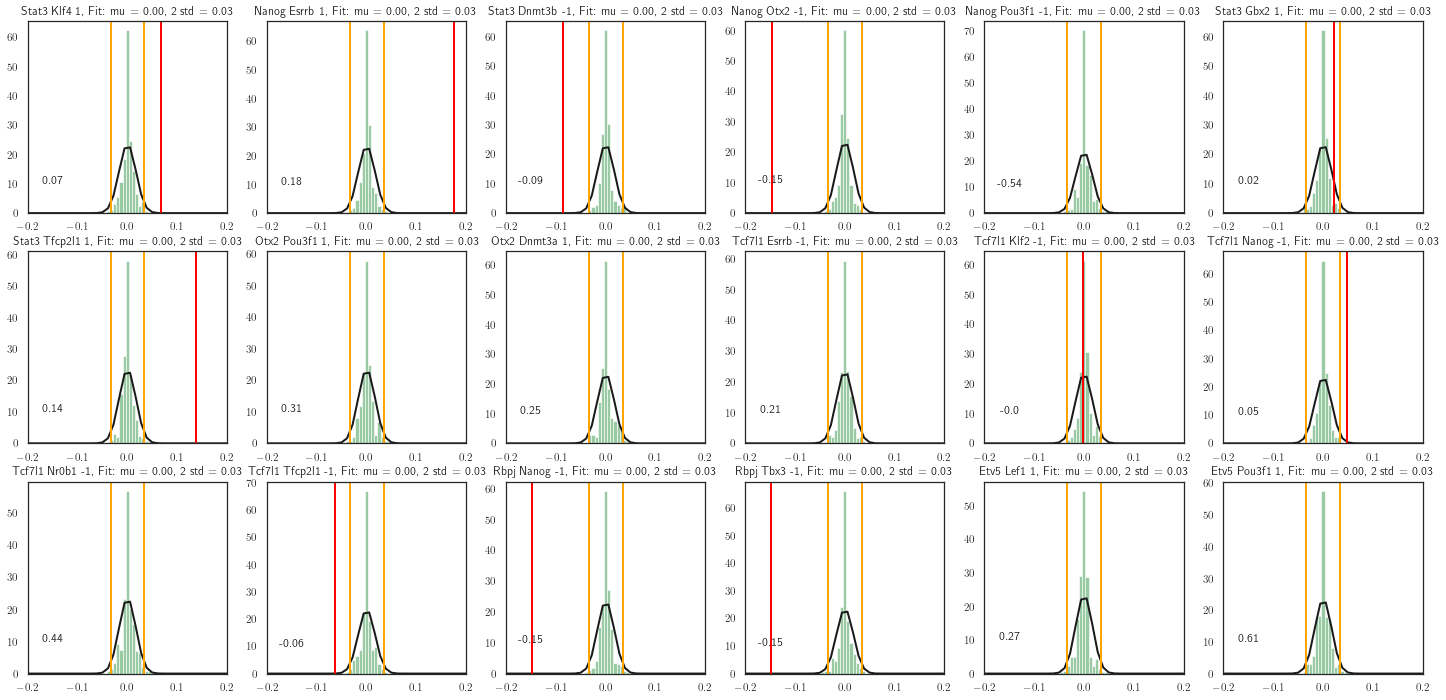

In [ ]:
lN_matx_sel_rnd_all = lN_matx_sel_rnd.reshape((50*50,24,24))

interactions_shuffled = TP_distribution(TPtrial_list, lN_matx_sel_rnd_all, genes_order)
interactions_shuffled.shape

check = len(TPtrial_list)

# Create a figure with 3 columns and 6 rows
fig, axs = plt.subplots(3, 6, figsize=(25,12))

# Iterate over the rows and columns of the subplot
for ii in range(lN_Mean_info_int.shape[1]):
    # Get the axis object for the current subplot
    ax = axs[ii // 6, ii % 6]
    
    # Plot the histogram
    bins_thr = 0.15
    bins= np.linspace(-bins_thr-0.1, bins_thr+0.1, 80)
    nn, _,_ = ax.hist(interactions_shuffled[ii,:], bins=bins, density=True, alpha=0.6, color='g')
    mu, std = norm.fit(interactions_shuffled)
    ax.set_xlim([-bins_thr-0.4, bins_thr+0.4])

    # Plot the PDF
    xmin, xmax = ax.get_xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    ax.plot(x, p, 'k', linewidth=2)
    ax.axvline(x=lN_Mean_info_int[2,ii], color="red", lw=2)
    std_range=2
    title = TPtrial_list[ii]+", Fit: mu = %.2f,  %.f std = %.2f" % (mu, std_range, std_range*std)
    ax.set_title(title)
    ax.axvline(x=mu+std*std_range, color="orange", lw=2)
    ax.axvline(x=mu-std*std_range, color="orange", lw=2)
    ax.text(-0.15, 10, np.round(lN_Mean_info_int[2,ii],2), fontsize=12, ha="center")
    ax.set_xlim([-0.2, 0.2])
#     print(lN_Mean_info_int[2,ii])
    if (lN_Mean_info_int[2,ii]<=(mu+std*std_range)) and (lN_Mean_info_int[2,ii]>=(mu-std*std_range)):
        print("IN random: ", TPtrial_list[ii], lN_Mean_info_int[2,ii], mu-std*std_range, mu+std*std_range)

        check -= 1
print("number of ints values far from the distribution: ", check)



In [ ]:
# from scipy.stats import norm
# from scipy.optimize import curve_fit
# check = len(TPtrial_list)

# for ii in range(raw_Mean_info_int.shape[1]):
#     plt.figure(figsize=(5,4))

#     # Plot the histogram
#     bins_thr = 0.25
#     bins= np.linspace(-bins_thr-0.1, bins_thr+0.1, 40)
#     nn, _,_ = plt.hist(interactions_shuffled[ii,:], bins=bins, density=True, alpha=0.6, color='g')
#     # Fit a normal distribution to the data
# #     interactions_shuff = interactions_shuffled[ii,:][interactions_shuffled[ii,:]>-bins_thr]
# #     interactions_shuff = interactions_shuff[interactions_shuff<bins_thr]
# #     mu, std = norm.fit(interactions_shuff)
#     mu, std = norm.fit(interactions_shuffled)
# #     centroids = (bins[1:]-bins[:-1])/2
# #     mean = sum(centroids*nn)
# # #     sigma = sum(nn*(centroids - mean)**2)
# #     def gauss_function(x, a, x0, sigma):
# #         return a*np.exp(-(x-x0)**2/(2*sigma**2))
# #     popt, pcov = curve_fit(gauss_function, centroids, nn)
# #     x = np.linspace(xmin, xmax, 100)
# #     plt.plot(centroids, gauss_function(centroids, *popt), label='fit')
#     plt.xlim([-bins_thr-0.4, bins_thr+0.4])

#     # Plot the PDF
#     xmin, xmax = plt.xlim()
#     x = np.linspace(xmin, xmax, 100)
#     p = norm.pdf(x, mu, std)
#     plt.plot(x, p, 'k', linewidth=2)
#     title = TPtrial_list[ii]+", Fit: mu = %.2f,  std = %.2f" % (mu, std)
#     plt.title(title)
#     plt.axvline(x=raw_Mean_info_int[2,ii], color="red", lw=2)
#     std_range=2
#     plt.axvline(x=mu+std*std_range, color="orange", lw=2)
#     plt.axvline(x=mu-std*std_range, color="orange", lw=2)
#     print(raw_Mean_info_int[2,ii])
#     if (raw_Mean_info_int[2,ii]>(mu+std*std_range)) or (raw_Mean_info_int[2,ii]<(mu-std*std_range)):
#         print("OUT random: ", TPtrial_list[ii])
#         check -= 1
#     plt.show()
# print(check)

# Save all Data

In [ ]:
# TRUE DATA
saving = True
if saving:
    # Raw TRUE data set
    np.savez('OUT_ISING/PsiNORM/pN_arrays_pst_MB_23_02_27.npz', array_1=pN_matx_sel_true, array_2=pN_prec_sel_true, array_3=pN_int_val_true)
    # LogNorm TRUE data set
#     np.savez('OUT_ISING/LogNORM/lN_arrays_pst_MB_23_02_27.npz', array_1=lN_matx_sel_true, array_2=lN_prec_sel_true, array_3=lN_int_val_true)

# TO LOAD
# raw_arrays = np.load('OUT_ISING/RAW/raw_arrays.npz')
# raw_matx_sel_true = my_arrays['array_1']
# raw_prec_sel_true = my_arrays['array_2']
# raw_int_val_true = my_arrays['array_3']

# lN_arrays = np.load('OUT_ISING/LogNORM/lN_arrays.npz')
# lN_matx_sel_true = my_arrays['array_1']
# lN_prec_sel_true = my_arrays['array_2']
# lN_int_val_true = my_arrays['array_3']


In [ ]:
# RANDOM DATA
saving = False
if saving:
    # Raw TRUE data set
    np.savez('OUT_ISING/RAW/pN_arrays_pst_MB_RND_23_1_23.npz', array_1=pN_matx_sel_rnd, array_2=pN_prec_sel_rnd, array_3=pN_int_val_rnd)
    # LogNorm TRUE data set
    np.savez('OUT_ISING/LogNORM/lN_arrays_pst_MB_RND_23_1_23.npz', array_1=lN_matx_sel_rnd, array_2=lN_prec_sel_rnd, array_3=lN_int_val_rnd)

# TO LOAD
# raw_arrays = np.load('OUT_ISING/RAW/raw_arrays_RND.npz')
# raw_matx_sel_rnd = my_arrays['array_1']
# raw_prec_sel_rnd = my_arrays['array_2']
# raw_int_val_rnd = my_arrays['array_3']

# lN_arrays = np.load('OUT_ISING/LogNORM/lN_arrays_RND.npz')
# lN_matx_sel_rnd = my_arrays['array_1']
# lN_prec_sel_rnd = my_arrays['array_2']
# lN_int_val_rnd = my_arrays['array_3']
